In [ ]:
import os
import librosa
from librosa.feature import melspectrogram
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from PIL import Image
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, classification_report

import torch
import torchvision
from torchvision.models import ResNet50_Weights, VGG16_Weights, DenseNet121_Weights
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.models as models
from torchvision.transforms import v2
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq '/content/drive/MyDrive/Colab_Notebooks/MER/spectrogram_224_5s.zip' -d "/content/"

# Hyperparameters

In [ ]:
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_DURATION = 5
RESIZE = 224

In [ ]:
DRIVE = '/content/'
AUDIO_DIR = DRIVE + 'audio/'
SPECTROGRAM_DIR = DRIVE + f'spectrogram_224_{SAMPLE_DURATION}s/'
VAL_AUDIO_DIR = 'val_audio/'
VAL_SPECTROGRAM_DIR = f'val_spectrogram_224_{SAMPLE_DURATION}s/'

ANNOTATIONS_FILE = DRIVE + 'annotations.csv'
VAL_ANNOTATIONS_FILE = 'val_annotations.csv'
NUM_CLASSES = 4
EMOTION_CLASSES = ['Happy', 'Calm', 'Angry', 'Sad']
EMOTION_MAP = {
        0: 'Happy',
        1: 'Calm',
        2: 'Angry',
        3: 'Sad'
    }

# Utilities

In [ ]:
def get_melsp(y, sr, resize, start_time, duration):
    """
    Generates a Mel-spectrogram image from a segment of an audio signal and normalizes it.

    Args:
        y (np.ndarray): Audio time-series data.
        sr (int): Sampling rate of the audio.
        resize (int): Size to resize the spectrogram image.
        start_time (float): Start time of the segment in seconds.
        duration (float): Duration of the segment in seconds.

    Returns:
        PIL.Image.Image: Image object of the Mel-spectrogram normalized and resized.
    """

    start_sample = int(start_time * sr)
    end_sample = start_sample + int(duration * sr)
    y_segment = y[start_sample:end_sample]

    mel_spect = librosa.feature.melspectrogram(y=y_segment, sr=sr,
                                               n_mels=N_MELS,
                                               n_fft=N_FFT,
                                               hop_length=HOP_LENGTH)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect_db = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())

    return Image.fromarray(mel_spect_db * 255).convert('L').resize((resize, resize), Image.LANCZOS)

In [ ]:
def map_arousal_valence_to_emotion(arousal, valence):
    """
    Maps arousal and valence values to discrete emotion classes.

    Args:
        arousal (float): Arousal value scaled from 1 to 9.
        valence (float): Valence value scaled from 1 to 9.

    Returns:
        int: Integer label corresponding to an emotion class.
            - 0: Happy
            - 1: Calm
            - 2: Angry
            - 3: Sad
            - -1: Undefined (if values do not fall into any defined range)
    """
    if 5 <= valence <= 9:
        if 5 <= arousal <= 9:
            return 0  # Happy
        elif 1 <= arousal < 5:
            return 1  # Calm
    elif 1 <= valence <= 5:
        if 5 <= arousal <= 9:
            return 2  # Angry
        elif 1 <= arousal < 5:
            return 3  # Sad

    return -1  # Undefined

In [ ]:
def grayscale_to_rgb(image):
    return Image.merge("RGB", (image, image, image))

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
class EmotionClassificationTrainer:
    def __init__(self, dataset, model_class, criterion_class, optimizer_class, scheduler_class,
                 device, batch_size, learning_rate, num_classes=4, k_folds=5, epochs=20, patience=5, class_weights=None):
        self.dataset = dataset
        self.model_class = model_class
        self.criterion_class = criterion_class
        self.optimizer_class = optimizer_class
        self.scheduler_class = scheduler_class
        self.device = device
        self.num_classes = num_classes
        self.k_folds = k_folds
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.learning_rate = learning_rate
        self.class_weights = class_weights

        self.train_losses, self.train_accuracies = [], []
        self.test_losses, self.test_accuracies = [], []
        self.val_losses, self.val_accuracies = [], []
        self.all_true_labels, self.all_predicted_labels = [], []

    def reset_model(self):
        model = self.model_class(self.num_classes).to(self.device)
        criterion = self.criterion_class(weight=self.class_weights)
        optimizer = self.optimizer_class(model.parameters(), lr=self.learning_rate)
        scheduler = self.scheduler_class(optimizer, step_size=5, gamma=0.1)
        return model, criterion, optimizer, scheduler

    def train_and_test(self, model, train_dataloader, test_dataloader, criterion, optimizer, scheduler):
        best_test_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            pbar_train = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{self.epochs}', unit='batch')

            for images, labels in pbar_train:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                pbar_train.set_postfix({'Loss': running_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

            # Calculate average training loss and accuracy for the epoch
            epoch_train_loss = running_loss / len(train_dataloader)
            epoch_train_accuracy = 100. * correct / total

            # Append to lists
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(epoch_train_accuracy)

            # Print epoch summary after completing training phase
            print(f'Epoch {epoch+1}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%')

            torch.cuda.empty_cache()

            scheduler.step()

            # Test phase (early stopping evaluation)
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0

            pbar_test = tqdm(test_dataloader, desc=f'Test Epoch {epoch+1}/{self.epochs}', unit='batch', leave=False)

            with torch.no_grad():
                for images, labels in pbar_test:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = model(images)

                    # Calculate loss
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    # Collect true and predicted labels
                    self.all_true_labels.extend(labels.cpu().numpy())
                    self.all_predicted_labels.extend(predicted.cpu().numpy())

                    pbar_test.set_postfix({'Loss': test_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

            # Calculate average Test loss and accuracy for the epoch
            epoch_test_loss = test_loss / len(test_dataloader)
            epoch_test_accuracy = 100. * correct / total

            # Append to lists
            self.test_losses.append(epoch_test_loss)
            self.test_accuracies.append(epoch_test_accuracy)

            # Print epoch summary after completing Test phase
            print(f'Epoch {epoch+1}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

            # Check for early stopping due to test loss
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print(f'Early stopping triggered after {epoch+1} epochs due to test loss')
                    break

        # Calculate precision, recall, and F1-score at the end
        final_precision = precision_score(self.all_true_labels, self.all_predicted_labels, average='weighted')
        final_recall = recall_score(self.all_true_labels, self.all_predicted_labels, average='weighted')
        final_f1_score = f1_score(self.all_true_labels, self.all_predicted_labels, average='weighted')

        print(f'Final Precision: {final_precision:.4f}, Final Recall: {final_recall:.4f}, Final F1-Score: {final_f1_score:.4f}')

        self.plot_confusion_matrix()
        self.generate_classification_report()

    def k_fold_cross_test(self):

        set_seed(616)

        if self.k_folds == 1:
            # Single Train-Test Split
            print('Single Train-Test Split')
            train_size = int(0.8 * len(self.dataset))
            indices = torch.randperm(len(self.dataset)).tolist()
            train_indices, test_indices = indices[:train_size], indices[train_size:]

            train_subset = Subset(self.dataset, train_indices)
            test_subset = Subset(self.dataset, test_indices)

            train_dataloader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
            test_dataloader = DataLoader(test_subset, batch_size=self.batch_size, shuffle=False)

            model, criterion, optimizer, scheduler = self.reset_model()
            self.train_and_test(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler)

        else:
            # K-Fold Cross-Validation
            kf = KFold(n_splits=self.k_folds, shuffle=True)
            fold_results = []

            for fold, (train_idx, test_idx) in enumerate(kf.split(self.dataset)):
                print(f'Fold {fold+1}/{self.k_folds}')

                train_subset = Subset(self.dataset, train_idx)
                test_subset = Subset(self.dataset, test_idx)

                train_dataloader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
                test_dataloader = DataLoader(test_subset, batch_size=self.batch_size, shuffle=False)

                model, criterion, optimizer, scheduler = self.reset_model()

                self.train_and_test(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler)

                fold_results.append({
                    'train_losses': self.train_losses,
                    'train_accuracies': self.train_accuracies,
                    'test_losses': self.test_losses,
                    'test_accuracies': self.test_accuracies
                })

                torch.save(model.state_dict(), DRIVE + 'v3y_es_model.pth')

            return fold_results

    def visualize_results(self, fold_results):
        if self.k_folds == 1:
            # Single train-test split case
            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.plot(self.train_losses, label='Train Loss')
            plt.plot(self.test_losses, label='Test Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Test Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(self.train_accuracies, label='Train Accuracy')
            plt.plot(self.test_accuracies, label='Test Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Training and Test Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()

            print(f'Final Training Loss: {self.train_losses[-1]:.4f}')
            print(f'Final Training Accuracy: {self.train_accuracies[-1]:.2f}%')
            print(f'Final Test Loss: {self.test_losses[-1]:.4f}')
            print(f'Final Test Accuracy: {self.test_accuracies[-1]:.2f}%')

        else:
            # K-Fold Cross-Validation case
            for fold, result in enumerate(fold_results):
                plt.figure(figsize=(10, 4))

                plt.subplot(1, 2, 1)
                plt.plot(result['train_losses'], label=f'Train Loss Fold {fold+1}')
                plt.plot(result['test_losses'], label=f'Test Loss Fold {fold+1}')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Fold {fold+1} Training and Test Loss')
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(result['train_accuracies'], label=f'Train Accuracy Fold {fold+1}')
                plt.plot(result['test_accuracies'], label=f'Test Accuracy Fold {fold+1}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title(f'Fold {fold+1} Training and Test Accuracy')
                plt.legend()

                plt.tight_layout()
                plt.show()

                print(f'Fold {fold+1} Final Training Loss: {result["train_losses"][-1]:.4f}')
                print(f'Fold {fold+1} Final Training Accuracy: {result["train_accuracies"][-1]:.2f}%')
                print(f'Fold {fold+1} Final Test Loss: {result["test_losses"][-1]:.4f}')
                print(f'Fold {fold+1} Final Test Accuracy: {result["test_accuracies"][-1]:.2f}%')

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.all_true_labels, self.all_predicted_labels)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Happy', 'Calm', 'Angry', 'Sad'],
                    yticklabels=['Happy', 'Calm', 'Angry', 'Sad'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def generate_classification_report(self):
        print(f"Final test accuracy: {self.test_accuracies[-1]:.2f}%")
        print(classification_report(self.all_true_labels, self.all_predicted_labels, target_names=['Happy', 'Calm', 'Angry', 'Sad']))

    def validate_model(self, model, val_dataloader, criterion):
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            pbar_val = tqdm(val_dataloader, desc='Validating', unit='batch')
            for images, labels in pbar_val:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                pbar_val.set_postfix({'Loss': val_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

        epoch_val_loss = val_loss / len(val_dataloader)
        epoch_val_accuracy = 100. * correct / total
        print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')

    def evaluate_single_song(self, audio_dir, filename, spectrogram_dir='single_songs/'):
        # Convert the audio file to a spectrogram
        audiofile_to_spectrogram(audio_dir, filename, spectrogram_dir)

        transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        # Load the spectrogram image
        base_filename = os.path.splitext(filename)[0]
        spectrogram_files = [f for f in os.listdir(spectrogram_dir)
                             if f.startswith(f'{base_filename}_segment_') and f.endswith('.png')]
        if not spectrogram_files:
            raise ValueError("No spectrogram images found in the specified directory.")

        # Assuming we use the first spectrogram image
        spectrogram_path = os.path.join(spectrogram_dir, spectrogram_files[0])

        # Load and preprocess the image
        image = Image.open(spectrogram_path).convert('RGB')
        image = transform(image)

        # Add batch dimension and move to device
        image = image.unsqueeze(0).to(self.device)

        # Set the model to evaluation mode
        self.model_class.eval()

        with torch.no_grad():
            outputs = self.model_class(image)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

        # Map the predicted label to emotion
        emotion = EMOTION_MAP.get(predicted_label, "Unknown")

        print(f'Predicted Emotion: {emotion}')

In [ ]:
def audio_to_spectrogram(audio_dir, spectrogram_dir):
    '''Converts audio to mel-spectrogram and saves in SPECTROGRAM_DIR'''
    if not os.path.exists(spectrogram_dir):
        os.makedirs(spectrogram_dir)
        print(f'Created directory: {spectrogram_dir}')
        print('Processing audio files...')
        for filename in os.listdir(audio_dir):
            if filename.endswith('.mp3'):
                audio_path = os.path.join(audio_dir, filename)
                y, sr = librosa.load(audio_path, sr=None)

                # Split into 5-second segments and process each
                total_duration = librosa.get_duration(y=y, sr=sr)
                num_segments = int(total_duration // SAMPLE_DURATION)

                for i in range(num_segments):
                    start_time = i * SAMPLE_DURATION
                    spectrogram_filename = f'{os.path.splitext(filename)[0]}_segment_{i}.png'
                    spectrogram_path = os.path.join(spectrogram_dir, spectrogram_filename)

                    mel_spect_img = get_melsp(y, sr, RESIZE, start_time, SAMPLE_DURATION)
                    mel_spect_img.save(spectrogram_path)
    else:
        print('Path exists.')
    print('Finished processing audio files.')

In [ ]:
def audiofile_to_spectrogram(audio_dir, filename, spectrogram_dir):
    '''Converts audio to mel-spectrogram and saves in SPECTROGRAM_DIR'''
    os.makedirs(spectrogram_dir, exist_ok=True)
    print('Processing audio file...')
    y, sr = librosa.load(audio_dir + filename, sr=None)

    # Split into 5-second segments and process each
    total_duration = librosa.get_duration(y=y, sr=sr)
    num_segments = int(total_duration // SAMPLE_DURATION)

    for i in range(num_segments):
        start_time = i * SAMPLE_DURATION
        spectrogram_filename = f'{os.path.splitext(filename)[0]}_segment_{i}.png'
        spectrogram_path = os.path.join(spectrogram_dir, spectrogram_filename)

        mel_spect_img = get_melsp(y, sr, RESIZE, start_time, SAMPLE_DURATION)
        mel_spect_img.save(spectrogram_path)
    print('Finished processing audio file.')

# Get Data

In [ ]:
class SpectrogramDataset(Dataset):
    EMOTION_MAP = {
        0: 'Happy',
        1: 'Calm',
        2: 'Angry',
        3: 'Sad'
    }

    def __init__(self, spectrogram_dir, annotations, transform=None):
        self.spectrogram_dir = spectrogram_dir
        self.annotations = annotations
        self.transform = transform

        # Calculate emotion labels and append as a new column
        self.annotations['emotion_label'] = self.annotations.apply(
            lambda row: map_arousal_valence_to_emotion(row[' arousal_mean'], row[' valence_mean']),
            axis=1
        )

        self.segmented_annotations = []
        for idx, row in self.annotations.iterrows():
            song_id = int(row['song_id'])
            emotion_label = int(row['emotion_label'])
            segment = 0
            while True:
                img_path = os.path.join(self.spectrogram_dir, f'{song_id}_segment_{segment}.png')
                if os.path.exists(img_path):
                    self.segmented_annotations.append((song_id, segment, emotion_label))
                    segment += 1
                else:
                    break

    def __len__(self):
        return len(self.segmented_annotations)

    def __getitem__(self, idx):
        song_id, segment, emotion_label = self.segmented_annotations[idx]
        img_path = os.path.join(self.spectrogram_dir, f'{song_id}_segment_{segment}.png')

        # Load image
        image = Image.open(img_path).convert('L')
        image = grayscale_to_rgb(image)

        if self.transform:
            image = self.transform(image)

        return image, emotion_label


In [ ]:
# transform = v2.Compose([
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Train and Test Dataset

In [ ]:
audio_to_spectrogram(AUDIO_DIR, SPECTROGRAM_DIR)

Path exists.
Finished processing audio files.


In [ ]:
annotations = pd.read_csv(ANNOTATIONS_FILE)
dataset = SpectrogramDataset(SPECTROGRAM_DIR, annotations, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f'Size of train dataset: {train_size}\nSize of test dataset: {test_size}')

Size of train dataset: 12549
Size of test dataset: 3138


## Validation Dataset

In [ ]:
# audio_to_spectrogram(VAL_AUDIO_DIR, VAL_SPECTROGRAM_DIR)

In [ ]:
# val_annotations = pd.read_csv(VAL_ANNOTATIONS_FILE)
# val_dataset = SpectrogramDataset(VAL_SPECTROGRAM_DIR, val_annotations, transform=transform)

# EDA

In [ ]:
df = pd.DataFrame(dataset.segmented_annotations, columns=['song_id', 'segment', 'emotion_label'])
# val_df = pd.DataFrame(val_dataset.segmented_annotations, columns=['song_id', 'segment', 'emotion_label'])

In [ ]:
df.head()

,song_id,segment,emotion_label
0,2,0,3
1,2,1,3
2,2,2,3
3,2,3,3
4,2,4,3


In [ ]:
# val_df.head()

In [ ]:
df['emotion_label'].value_counts()

emotion_label
3    6036
0    5703
1    1998
2    1950
Name: count, dtype: int64

In [ ]:
def plot_valence_arousal_distribution(df):
    plt.figure(figsize=(9, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[' valence_mean'], kde=True, bins=30)
    plt.title('Distribution of Valence Mean')
    plt.xlabel('Valence Mean')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df[' arousal_mean'], kde=True, bins=30)
    plt.title('Distribution of Arousal Mean')
    plt.xlabel('Arousal Mean')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def scatter_valence_arousal(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=' valence_mean', y=' arousal_mean', hue='emotion_label', data=df, palette='tab10')
    plt.title('Scatter Plot of Valence vs Arousal')
    plt.xlabel('Valence Mean')
    plt.ylabel('Arousal Mean')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

def barplot_emotion_counts(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='emotion_label', hue='emotion_label', data=df, palette='tab10', order=df['emotion_label'].value_counts().index, legend=False)
    plt.title('Counts of Each Emotion Label')
    plt.xlabel('Emotion Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

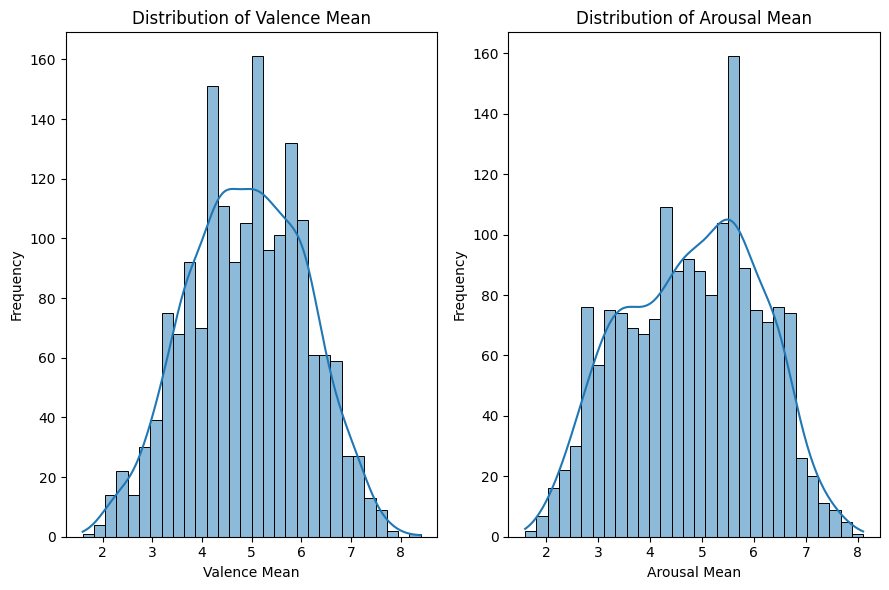

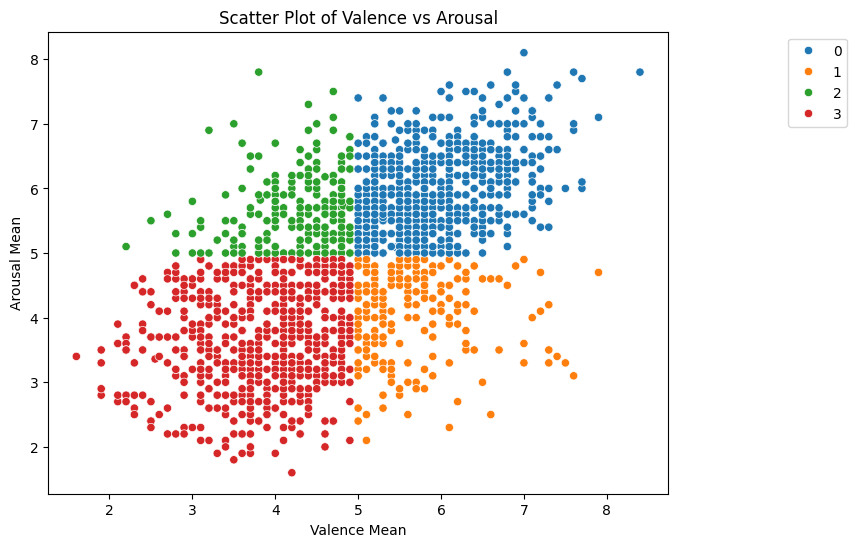

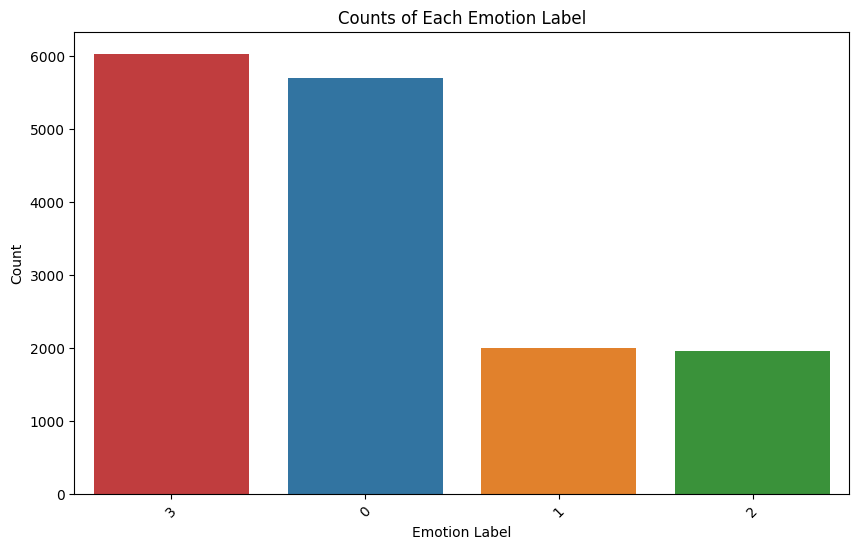

In [ ]:
plot_valence_arousal_distribution(annotations)
scatter_valence_arousal(annotations)
barplot_emotion_counts(df)

In [ ]:
# plot_valence_arousal_distribution(val_annotations)
# scatter_valence_arousal(val_annotations)
# barplot_emotion_counts(val_df)

# Define Models

In [ ]:
# class ResNet50(nn.Module):
#     def __init__(self, num_classes):
#         super(ResNet50, self).__init__()
#         self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
#         num_features = self.resnet.fc.in_features
#         self.resnet.fc = nn.Linear(num_features, num_classes)

#     def forward(self, x):
#         return self.resnet(x)

class ResNet50(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features

        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


In [ ]:
# class VGG16(nn.Module):
#     def __init__(self, num_classes):
#         super(VGG16, self).__init__()
#         self.vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
#         num_features = self.vgg16.classifier[6].in_features
#         self.vgg16.classifier[6] = nn.Linear(num_features, num_classes)

#     def forward(self, x):
#         return self.vgg16(x)

class VGG16(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.2):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.vgg16(x)


In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.6):
        super().__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        num_features = self.densenet.classifier.in_features

        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

In [ ]:
# class StackingEnsemble(nn.Module):
#     def __init__(self, num_classes):
#         super(StackingEnsemble, self).__init__()
#         self.resnet50 = ResNet50(num_classes)
#         self.vgg16 = VGG16(num_classes)
#         self.densenet121 = DenseNet121(num_classes)
#         combined_features = num_classes * 3 # 3 models
#         self.meta_classifier = nn.Linear(combined_features, num_classes)

#     def forward(self, x):
#         resnet_out = self.resnet50(x)
#         vgg_out = self.vgg16(x)
#         densenet_out = self.densenet121(x)
#         combined = torch.cat((resnet_out, vgg_out, densenet_out), dim=1)
#         return self.meta_classifier(combined)

class StackingEnsemble(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(StackingEnsemble, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.num_classes = num_classes

        self.resnet50 = ResNet50(num_classes).to(self.device)
        self.vgg16 = VGG16(num_classes).to(self.device)
        self.densenet121 = DenseNet121(num_classes).to(self.device)

        combined_features = num_classes * 3  # 3 models
        self.dropout = nn.Dropout(dropout_prob)
        self.meta_classifier = nn.Linear(combined_features, num_classes)

        # Load pre-trained weights
        self.resnet50.load_state_dict(torch.load(DRIVE + 'v2y_rn_model.pth', weights_only=True))
        self.vgg16.load_state_dict(torch.load(DRIVE + 'v2y_vgg_model.pth', weights_only=True))
        self.densenet121.load_state_dict(torch.load(DRIVE + 'v3y_dn_model.pth', weights_only=True))

    def forward(self, x):
        resnet_out = self.resnet50(x)
        vgg_out = self.vgg16(x)
        densenet_out = self.densenet121(x)

        combined = torch.cat((resnet_out, vgg_out, densenet_out), dim=1)
        combined = self.dropout(combined)
        return self.meta_classifier(combined)

# Train and Test Models

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
df['emotion_label'].value_counts()

emotion_label
3    6036
0    5703
1    1998
2    1950
Name: count, dtype: int64

In [ ]:
# val_df['emotion_label'].value_counts()

In [ ]:
# Manual input
# class_counts = {'Happy': 1899, 'Calm': 666, 'Angry': 648, 'Sad': 2010} # 15s segment
class_counts = {'Happy': 5703, 'Calm': 1998, 'Angry': 1950, 'Sad': 6036} # 5s segment
total_samples = sum(class_counts.values())
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts.values()]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights

tensor([0.6877, 1.9628, 2.0112, 0.6497], device='cuda:0')

In [ ]:
# val_class_counts = {'Happy': 470, 'Calm': 852, 'Angry': 719, 'Sad': 645} # 5s segment
# val_total_samples = sum(val_class_counts.values())
# val_class_weights = [val_total_samples / (len(val_class_counts) * count) for count in val_class_counts.values()]
# val_class_weights = torch.tensor(val_class_weights, dtype=torch.float32).to(device)
# val_class_weights

## ResNet50

### 15s

In [ ]:
v1_rn_model = ResNet50(NUM_CLASSES).to(device)
v1_rn = EmotionClassificationTrainer(dataset=dataset,
                                     model=v1_rn_model,
                                     criterion_class=nn.CrossEntropyLoss,
                                     optimizer_class=optim.Adam,
                                     scheduler_class=StepLR,
                                     device=device,
                                     batch_size=16,
                                     learning_rate=0.01,
                                     k_folds=1,
                                     class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|████████████████████████████| 262/262 [00:59<00:00,  4.42batch/s, Loss=0.0899, Accuracy=31.5]


Epoch 1, Training Loss: 1.4334, Training Accuracy: 31.47%


Epoch 1, Test Loss: 1.4048, Test Accuracy: 22.87%


Training Epoch 2/20: 100%|████████████████████████████| 262/262 [01:00<00:00,  4.30batch/s, Loss=0.0886, Accuracy=33.7]


Epoch 2, Training Loss: 1.4122, Training Accuracy: 33.65%


Epoch 2, Test Loss: 1.3892, Test Accuracy: 39.71%


Training Epoch 3/20: 100%|████████████████████████████| 262/262 [01:02<00:00,  4.19batch/s, Loss=0.0894, Accuracy=42.6]


Epoch 3, Training Loss: 1.4251, Training Accuracy: 42.60%


Epoch 3, Test Loss: 1.3560, Test Accuracy: 53.78%


Training Epoch 4/20: 100%|████████████████████████████| 262/262 [01:02<00:00,  4.20batch/s, Loss=0.0814, Accuracy=52.3]


Epoch 4, Training Loss: 1.2977, Training Accuracy: 52.35%


Epoch 4, Test Loss: 1.4917, Test Accuracy: 34.74%


Training Epoch 5/20: 100%|████████████████████████████| 262/262 [01:02<00:00,  4.19batch/s, Loss=0.0807, Accuracy=53.8]


Epoch 5, Training Loss: 1.2873, Training Accuracy: 53.76%


Epoch 5, Test Loss: 1.2764, Test Accuracy: 43.64%


Training Epoch 6/20: 100%|████████████████████████████| 262/262 [01:02<00:00,  4.19batch/s, Loss=0.0792, Accuracy=54.3]


Epoch 6, Training Loss: 1.2625, Training Accuracy: 54.33%


Epoch 6, Test Loss: 1.2494, Test Accuracy: 54.74%


Training Epoch 7/20: 100%|████████████████████████████| 262/262 [01:02<00:00,  4.17batch/s, Loss=0.0782, Accuracy=56.8]


Epoch 7, Training Loss: 1.2468, Training Accuracy: 56.82%


Epoch 7, Test Loss: 1.2529, Test Accuracy: 54.83%


Training Epoch 8/20: 100%|████████████████████████████| 262/262 [01:02<00:00,  4.19batch/s, Loss=0.0783, Accuracy=55.1]


Epoch 8, Training Loss: 1.2485, Training Accuracy: 55.10%


Epoch 8, Test Loss: 1.2442, Test Accuracy: 56.84%


Training Epoch 9/20: 100%|████████████████████████████| 262/262 [01:03<00:00,  4.12batch/s, Loss=0.0776, Accuracy=57.1]


Epoch 9, Training Loss: 1.2376, Training Accuracy: 57.11%


Epoch 9, Test Loss: 1.2278, Test Accuracy: 55.89%


Training Epoch 10/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.18batch/s, Loss=0.0769, Accuracy=55.9]


Epoch 10, Training Loss: 1.2267, Training Accuracy: 55.91%


Epoch 10, Test Loss: 1.2306, Test Accuracy: 55.60%


Training Epoch 11/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.20batch/s, Loss=0.0767, Accuracy=57.9]


Epoch 11, Training Loss: 1.2224, Training Accuracy: 57.90%


Epoch 11, Test Loss: 1.2279, Test Accuracy: 57.13%


Training Epoch 12/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.19batch/s, Loss=0.0761, Accuracy=57.3]


Epoch 12, Training Loss: 1.2130, Training Accuracy: 57.25%


Epoch 12, Test Loss: 1.2226, Test Accuracy: 57.51%


Training Epoch 13/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.19batch/s, Loss=0.0762, Accuracy=57.8]


Epoch 13, Training Loss: 1.2147, Training Accuracy: 57.78%


Epoch 13, Test Loss: 1.2243, Test Accuracy: 57.42%


Training Epoch 14/20: 100%|█████████████████████████████| 262/262 [01:03<00:00,  4.13batch/s, Loss=0.0757, Accuracy=58]


Epoch 14, Training Loss: 1.2073, Training Accuracy: 58.04%


Epoch 14, Test Loss: 1.2022, Test Accuracy: 57.61%


Training Epoch 15/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.19batch/s, Loss=0.0751, Accuracy=58.4]


Epoch 15, Training Loss: 1.1980, Training Accuracy: 58.38%


Epoch 15, Test Loss: 1.2160, Test Accuracy: 57.51%


Training Epoch 16/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.17batch/s, Loss=0.0744, Accuracy=58.8]


Epoch 16, Training Loss: 1.1870, Training Accuracy: 58.81%


Epoch 16, Test Loss: 1.2022, Test Accuracy: 57.99%


Training Epoch 17/20: 100%|███████████████████████████| 262/262 [01:03<00:00,  4.15batch/s, Loss=0.0748, Accuracy=58.3]


Epoch 17, Training Loss: 1.1922, Training Accuracy: 58.26%


Epoch 17, Test Loss: 1.1858, Test Accuracy: 59.14%


Training Epoch 18/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.18batch/s, Loss=0.0749, Accuracy=58.4]


Epoch 18, Training Loss: 1.1944, Training Accuracy: 58.35%


Epoch 18, Test Loss: 1.1879, Test Accuracy: 57.80%


Training Epoch 19/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.18batch/s, Loss=0.0748, Accuracy=59.2]


Epoch 19, Training Loss: 1.1923, Training Accuracy: 59.19%


Epoch 19, Test Loss: 1.1887, Test Accuracy: 57.80%


Training Epoch 20/20: 100%|███████████████████████████| 262/262 [01:02<00:00,  4.20batch/s, Loss=0.0744, Accuracy=59.1]


Epoch 20, Training Loss: 1.1872, Training Accuracy: 59.14%


Epoch 20, Test Loss: 1.1887, Test Accuracy: 58.56%
Final Precision: 0.4999, Final Recall: 0.5256, Final F1-Score: 0.5068


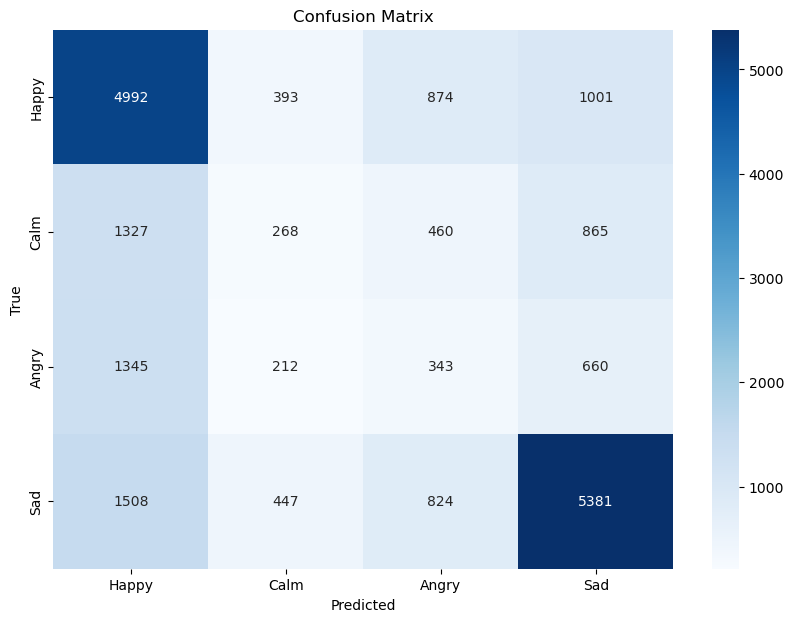

Final test accuracy: 58.56%
              precision    recall  f1-score   support

       Happy       0.54      0.69      0.61      7260
        Calm       0.20      0.09      0.13      2920
       Angry       0.14      0.13      0.14      2560
         Sad       0.68      0.66      0.67      8160

    accuracy                           0.53     20900
   macro avg       0.39      0.39      0.38     20900
weighted avg       0.50      0.53      0.51     20900



In [ ]:
v1_rn_results = v1_rn.k_fold_cross_test()

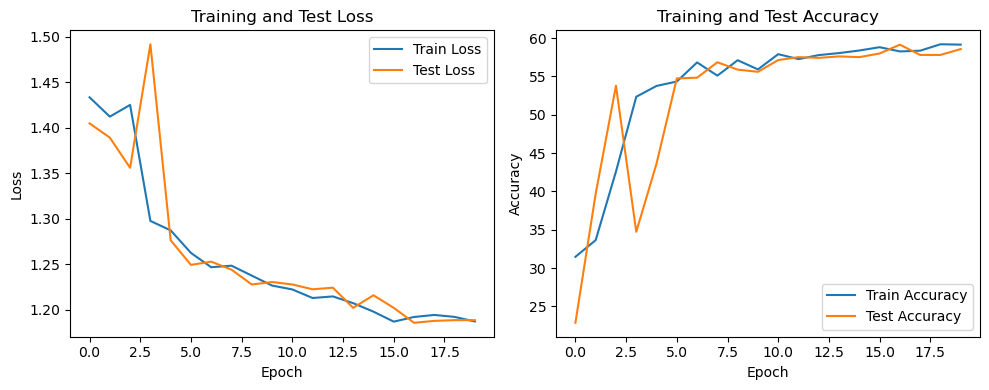

Final Training Loss: 1.1872
Final Training Accuracy: 59.14%
Final Test Loss: 1.1887
Final Test Accuracy: 58.56%


In [ ]:
v1_rn.visualize_results(v1_rn_results)

In [ ]:
torch.save(v1_rn_model.state_dict(), 'v1x_rn_model.pth')

### 5s

In [ ]:
v2_rn_model = ResNet50().to(device)
v2_rn = EmotionClassificationTrainer(dataset=dataset,
                                     model=v2_rn_model,
                                     criterion_class=nn.CrossEntropyLoss,
                                     optimizer_class=optim.Adam,
                                     scheduler_class=StepLR,
                                     device=device,
                                     batch_size=16,
                                     learning_rate=0.0001,
                                     k_folds=1,
                                     class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|██████████████████████████████| 785/785 [03:11<00:00,  4.10batch/s, Loss=0.0741, Accuracy=55]


Epoch 1, Training Loss: 1.1853, Training Accuracy: 55.03%


Epoch 1, Test Loss: 1.0747, Test Accuracy: 59.34%


Training Epoch 2/20: 100%|████████████████████████████| 785/785 [03:11<00:00,  4.09batch/s, Loss=0.0667, Accuracy=60.4]


Epoch 2, Training Loss: 1.0668, Training Accuracy: 60.36%


Epoch 2, Test Loss: 0.9703, Test Accuracy: 63.80%


Training Epoch 3/20: 100%|████████████████████████████| 785/785 [03:10<00:00,  4.12batch/s, Loss=0.0609, Accuracy=62.7]


Epoch 3, Training Loss: 0.9733, Training Accuracy: 62.71%


Epoch 3, Test Loss: 0.9072, Test Accuracy: 63.96%


Training Epoch 4/20: 100%|████████████████████████████| 785/785 [03:11<00:00,  4.11batch/s, Loss=0.0544, Accuracy=66.7]


Epoch 4, Training Loss: 0.8704, Training Accuracy: 66.66%


Epoch 4, Test Loss: 0.8043, Test Accuracy: 70.04%


Training Epoch 5/20: 100%|████████████████████████████| 785/785 [03:13<00:00,  4.06batch/s, Loss=0.0478, Accuracy=70.6]


Epoch 5, Training Loss: 0.7649, Training Accuracy: 70.59%


Epoch 5, Test Loss: 0.7358, Test Accuracy: 72.66%


Training Epoch 6/20: 100%|████████████████████████████| 785/785 [03:24<00:00,  3.84batch/s, Loss=0.0371, Accuracy=76.8]


Epoch 6, Training Loss: 0.5928, Training Accuracy: 76.80%


Epoch 6, Test Loss: 0.6375, Test Accuracy: 75.53%


Training Epoch 7/20: 100%|████████████████████████████| 785/785 [03:28<00:00,  3.77batch/s, Loss=0.0323, Accuracy=80.2]


Epoch 7, Training Loss: 0.5163, Training Accuracy: 80.25%


Epoch 7, Test Loss: 0.6192, Test Accuracy: 75.88%


Training Epoch 8/20: 100%|████████████████████████████| 785/785 [03:23<00:00,  3.87batch/s, Loss=0.0298, Accuracy=81.2]


Epoch 8, Training Loss: 0.4763, Training Accuracy: 81.19%


Epoch 8, Test Loss: 0.5844, Test Accuracy: 78.27%


Training Epoch 9/20: 100%|████████████████████████████| 785/785 [03:20<00:00,  3.91batch/s, Loss=0.0284, Accuracy=82.6]


Epoch 9, Training Loss: 0.4541, Training Accuracy: 82.60%


Epoch 9, Test Loss: 0.5718, Test Accuracy: 79.38%


Training Epoch 10/20: 100%|███████████████████████████| 785/785 [03:09<00:00,  4.14batch/s, Loss=0.0257, Accuracy=83.9]


Epoch 10, Training Loss: 0.4111, Training Accuracy: 83.90%


Epoch 10, Test Loss: 0.5737, Test Accuracy: 80.08%


Training Epoch 11/20: 100%|███████████████████████████| 785/785 [03:11<00:00,  4.09batch/s, Loss=0.0248, Accuracy=85.1]


Epoch 11, Training Loss: 0.3968, Training Accuracy: 85.12%


Epoch 11, Test Loss: 0.5715, Test Accuracy: 80.31%


Training Epoch 12/20: 100%|███████████████████████████| 785/785 [03:10<00:00,  4.13batch/s, Loss=0.0245, Accuracy=84.4]


Epoch 12, Training Loss: 0.3909, Training Accuracy: 84.38%


Epoch 12, Test Loss: 0.5727, Test Accuracy: 79.19%


Training Epoch 13/20: 100%|█████████████████████████████| 785/785 [03:19<00:00,  3.93batch/s, Loss=0.0238, Accuracy=85]


Epoch 13, Training Loss: 0.3797, Training Accuracy: 84.97%


Epoch 13, Test Loss: 0.5623, Test Accuracy: 79.51%


Training Epoch 14/20: 100%|███████████████████████████| 785/785 [03:08<00:00,  4.16batch/s, Loss=0.0238, Accuracy=84.9]


Epoch 14, Training Loss: 0.3800, Training Accuracy: 84.88%


Epoch 14, Test Loss: 0.5624, Test Accuracy: 80.24%


Training Epoch 15/20: 100%|█████████████████████████████| 785/785 [03:09<00:00,  4.13batch/s, Loss=0.0234, Accuracy=85]


Epoch 15, Training Loss: 0.3734, Training Accuracy: 85.03%


Epoch 15, Test Loss: 0.5589, Test Accuracy: 79.67%


Training Epoch 16/20: 100%|█████████████████████████████| 785/785 [03:07<00:00,  4.20batch/s, Loss=0.0231, Accuracy=86]


Epoch 16, Training Loss: 0.3700, Training Accuracy: 85.97%


Epoch 16, Test Loss: 0.5682, Test Accuracy: 79.51%


Training Epoch 17/20: 100%|███████████████████████████| 785/785 [03:11<00:00,  4.09batch/s, Loss=0.0233, Accuracy=85.7]


Epoch 17, Training Loss: 0.3725, Training Accuracy: 85.66%


Epoch 17, Test Loss: 0.5539, Test Accuracy: 80.05%


Training Epoch 18/20: 100%|███████████████████████████| 785/785 [03:05<00:00,  4.22batch/s, Loss=0.0231, Accuracy=85.8]


Epoch 18, Training Loss: 0.3696, Training Accuracy: 85.80%


Epoch 18, Test Loss: 0.5688, Test Accuracy: 79.76%


Training Epoch 19/20: 100%|███████████████████████████| 785/785 [03:05<00:00,  4.22batch/s, Loss=0.0235, Accuracy=85.5]


Epoch 19, Training Loss: 0.3752, Training Accuracy: 85.47%


Epoch 19, Test Loss: 0.5476, Test Accuracy: 80.34%


Training Epoch 20/20: 100%|███████████████████████████| 785/785 [03:14<00:00,  4.05batch/s, Loss=0.0229, Accuracy=85.6]


Epoch 20, Training Loss: 0.3662, Training Accuracy: 85.63%


Epoch 20, Test Loss: 0.5835, Test Accuracy: 78.84%
Final Precision: 0.7828, Final Recall: 0.7582, Final F1-Score: 0.7656


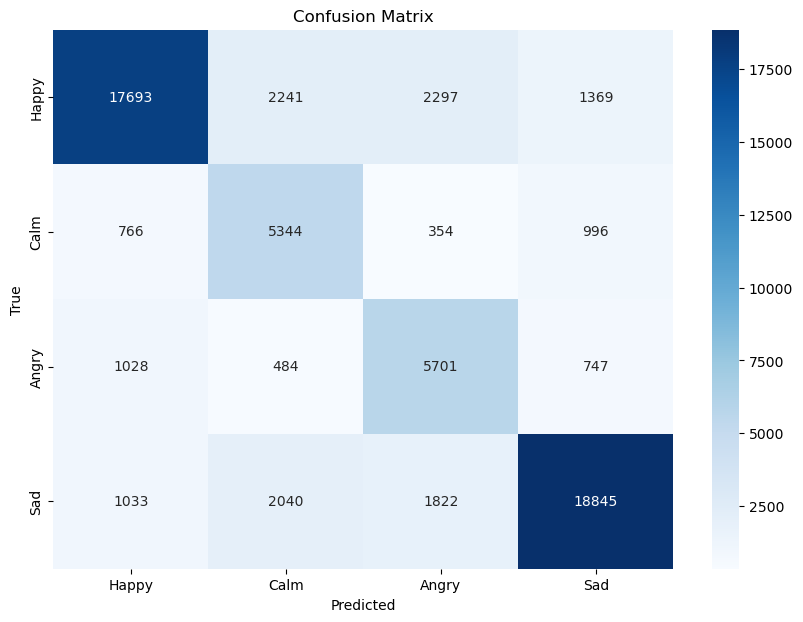

Final test accuracy: 78.84%
              precision    recall  f1-score   support

       Happy       0.86      0.75      0.80     23600
        Calm       0.53      0.72      0.61      7460
       Angry       0.56      0.72      0.63      7960
         Sad       0.86      0.79      0.82     23740

    accuracy                           0.76     62760
   macro avg       0.70      0.74      0.72     62760
weighted avg       0.78      0.76      0.77     62760



In [ ]:
v2_rn_results = v2_rn.k_fold_cross_test()

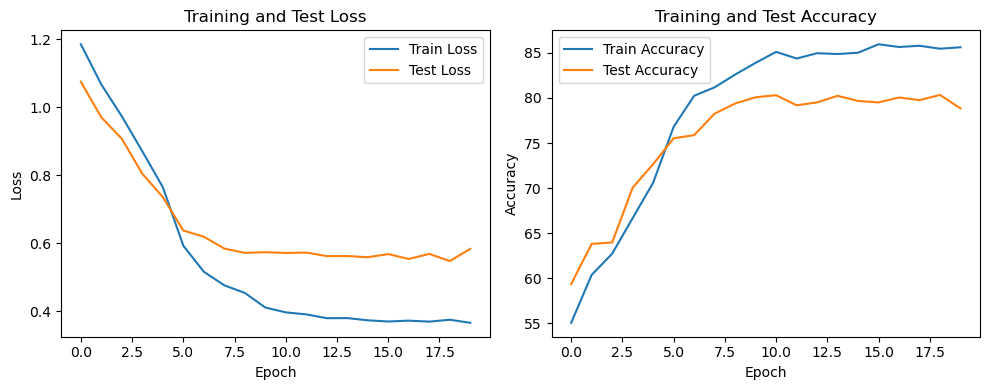

Final Training Loss: 0.3662
Final Training Accuracy: 85.63%
Final Test Loss: 0.5835
Final Test Accuracy: 78.84%


In [ ]:
v2_rn.visualize_results(v2_rn_results)

In [ ]:
torch.save(v2_rn_model.state_dict(), 'v2y_rn_model.pth')

## VGG16

### 15s

In [ ]:
v1_vgg_model = VGG16().to(device)
v1_vgg = EmotionClassificationTrainer(dataset=dataset,
                                      model=v1_vgg_model,
                                      criterion_class=nn.CrossEntropyLoss,
                                      optimizer_class=optim.Adam,
                                      scheduler_class=StepLR,
                                      device=device,
                                      batch_size=16,
                                      learning_rate=0.0001,
                                      k_folds=1,
                                      class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|████████████████████████████| 262/262 [02:20<00:00,  1.86batch/s, Loss=0.0814, Accuracy=51.6]


Epoch 1, Training Loss: 1.2986, Training Accuracy: 51.63%


Epoch 1, Test Loss: 1.5123, Test Accuracy: 47.66%


Training Epoch 2/20: 100%|████████████████████████████| 262/262 [02:27<00:00,  1.77batch/s, Loss=0.0768, Accuracy=58.4]


Epoch 2, Training Loss: 1.2254, Training Accuracy: 58.45%


Epoch 2, Test Loss: 1.2191, Test Accuracy: 56.65%


Training Epoch 3/20: 100%|████████████████████████████| 262/262 [02:40<00:00,  1.63batch/s, Loss=0.0736, Accuracy=60.7]


Epoch 3, Training Loss: 1.1732, Training Accuracy: 60.67%


Epoch 3, Test Loss: 1.3347, Test Accuracy: 57.61%


Training Epoch 4/20: 100%|████████████████████████████| 262/262 [02:37<00:00,  1.67batch/s, Loss=0.0744, Accuracy=59.9]


Epoch 4, Training Loss: 1.1860, Training Accuracy: 59.91%


Epoch 4, Test Loss: 1.1846, Test Accuracy: 62.68%


Training Epoch 5/20: 100%|██████████████████████████████| 262/262 [02:40<00:00,  1.64batch/s, Loss=0.0717, Accuracy=62]


Epoch 5, Training Loss: 1.1436, Training Accuracy: 61.97%


Epoch 5, Test Loss: 1.1785, Test Accuracy: 59.33%


Training Epoch 6/20: 100%|████████████████████████████| 262/262 [02:42<00:00,  1.61batch/s, Loss=0.0695, Accuracy=62.7]


Epoch 6, Training Loss: 1.1077, Training Accuracy: 62.66%


Epoch 6, Test Loss: 1.1271, Test Accuracy: 61.15%


Training Epoch 7/20: 100%|████████████████████████████| 262/262 [02:41<00:00,  1.63batch/s, Loss=0.0675, Accuracy=63.4]


Epoch 7, Training Loss: 1.0770, Training Accuracy: 63.36%


Epoch 7, Test Loss: 1.1056, Test Accuracy: 62.58%


Training Epoch 8/20: 100%|████████████████████████████| 262/262 [02:25<00:00,  1.80batch/s, Loss=0.0673, Accuracy=62.4]


Epoch 8, Training Loss: 1.0735, Training Accuracy: 62.45%


Epoch 8, Test Loss: 1.0954, Test Accuracy: 62.68%


Training Epoch 9/20: 100%|████████████████████████████| 262/262 [02:19<00:00,  1.88batch/s, Loss=0.0662, Accuracy=63.2]


Epoch 9, Training Loss: 1.0553, Training Accuracy: 63.16%


Epoch 9, Test Loss: 1.0956, Test Accuracy: 61.34%


Training Epoch 10/20: 100%|███████████████████████████| 262/262 [02:13<00:00,  1.96batch/s, Loss=0.0661, Accuracy=62.8]


Epoch 10, Training Loss: 1.0546, Training Accuracy: 62.76%


Epoch 10, Test Loss: 1.0990, Test Accuracy: 62.20%


Training Epoch 11/20: 100%|███████████████████████████| 262/262 [02:13<00:00,  1.96batch/s, Loss=0.0653, Accuracy=64.5]


Epoch 11, Training Loss: 1.0417, Training Accuracy: 64.48%


Epoch 11, Test Loss: 1.1006, Test Accuracy: 62.30%


Training Epoch 12/20: 100%|█████████████████████████████| 262/262 [02:12<00:00,  1.97batch/s, Loss=0.0653, Accuracy=64]


Epoch 12, Training Loss: 1.0411, Training Accuracy: 64.00%


Epoch 12, Test Loss: 1.0895, Test Accuracy: 62.78%


Training Epoch 13/20: 100%|███████████████████████████| 262/262 [02:12<00:00,  1.98batch/s, Loss=0.0654, Accuracy=64.2]


Epoch 13, Training Loss: 1.0431, Training Accuracy: 64.17%


Epoch 13, Test Loss: 1.1018, Test Accuracy: 60.29%


Training Epoch 14/20: 100%|███████████████████████████| 262/262 [02:12<00:00,  1.98batch/s, Loss=0.0648, Accuracy=64.3]


Epoch 14, Training Loss: 1.0327, Training Accuracy: 64.31%


Epoch 14, Test Loss: 1.0933, Test Accuracy: 62.11%


Training Epoch 15/20: 100%|███████████████████████████| 262/262 [02:12<00:00,  1.98batch/s, Loss=0.0648, Accuracy=64.4]


Epoch 15, Training Loss: 1.0335, Training Accuracy: 64.36%


Epoch 15, Test Loss: 1.0837, Test Accuracy: 62.30%


Training Epoch 16/20: 100%|███████████████████████████| 262/262 [02:12<00:00,  1.98batch/s, Loss=0.0646, Accuracy=64.5]


Epoch 16, Training Loss: 1.0295, Training Accuracy: 64.50%


Epoch 16, Test Loss: 1.0918, Test Accuracy: 61.91%


Training Epoch 17/20: 100%|███████████████████████████| 262/262 [02:14<00:00,  1.94batch/s, Loss=0.0646, Accuracy=64.8]


Epoch 17, Training Loss: 1.0297, Training Accuracy: 64.84%


Epoch 17, Test Loss: 1.0849, Test Accuracy: 61.53%


Training Epoch 18/20: 100%|███████████████████████████| 262/262 [02:19<00:00,  1.87batch/s, Loss=0.0648, Accuracy=64.1]


Epoch 18, Training Loss: 1.0326, Training Accuracy: 64.15%


Epoch 18, Test Loss: 1.0937, Test Accuracy: 61.53%


Training Epoch 19/20: 100%|███████████████████████████| 262/262 [02:12<00:00,  1.98batch/s, Loss=0.0646, Accuracy=64.5]


Epoch 19, Training Loss: 1.0297, Training Accuracy: 64.50%


Epoch 19, Test Loss: 1.0811, Test Accuracy: 62.20%


Training Epoch 20/20: 100%|███████████████████████████| 262/262 [02:14<00:00,  1.94batch/s, Loss=0.0649, Accuracy=64.6]


Epoch 20, Training Loss: 1.0343, Training Accuracy: 64.55%


Epoch 20, Test Loss: 1.0865, Test Accuracy: 61.34%
Final Precision: 0.5805, Final Recall: 0.6061, Final F1-Score: 0.5899


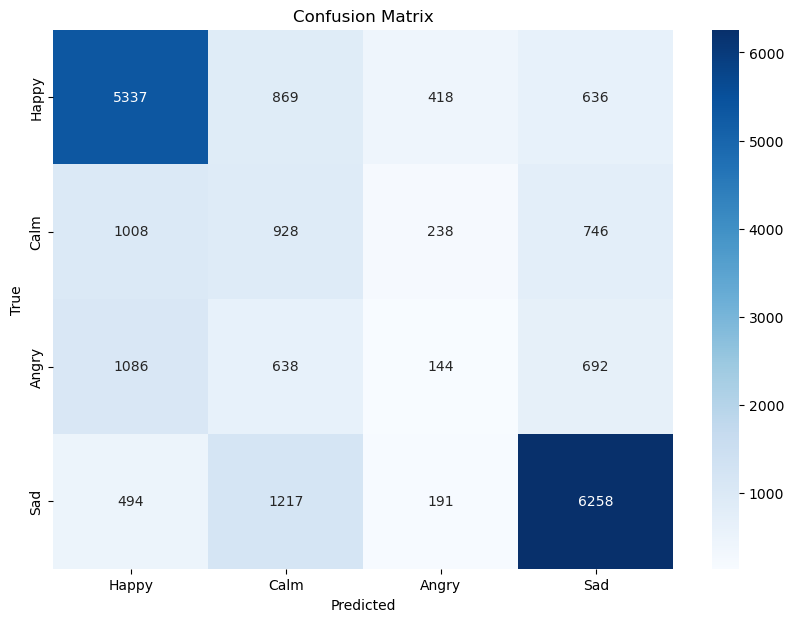

Final test accuracy: 61.34%
              precision    recall  f1-score   support

       Happy       0.67      0.74      0.70      7260
        Calm       0.25      0.32      0.28      2920
       Angry       0.15      0.06      0.08      2560
         Sad       0.75      0.77      0.76      8160

    accuracy                           0.61     20900
   macro avg       0.46      0.47      0.46     20900
weighted avg       0.58      0.61      0.59     20900



In [ ]:
v1_vgg_results = v1_vgg.k_fold_cross_test()

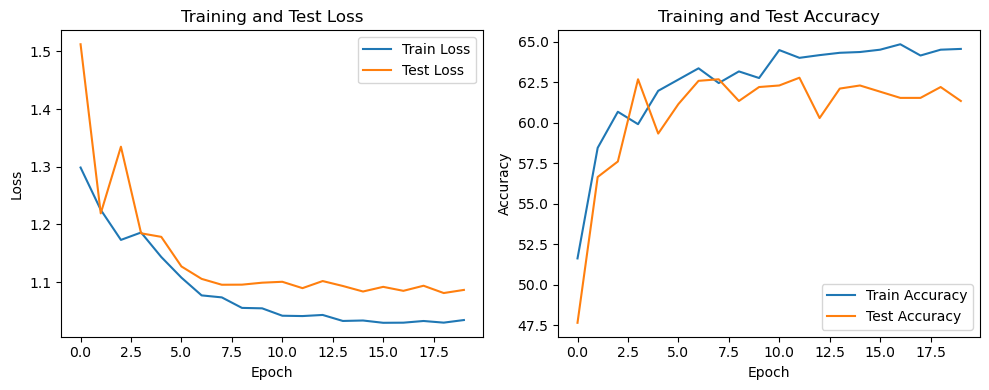

Final Training Loss: 1.0343
Final Training Accuracy: 64.55%
Final Test Loss: 1.0865
Final Test Accuracy: 61.34%


In [ ]:
v1_vgg.visualize_results(v1_vgg_results)

In [ ]:
torch.save(v1_vgg_model.state_dict(), 'v1x_vgg_model.pth')

### 5s

In [ ]:
v2_vgg_model = VGG16().to(device)
v2_vgg = EmotionClassificationTrainer(dataset=dataset,
                                      model=v2_vgg_model,
                                      criterion_class=nn.CrossEntropyLoss,
                                      optimizer_class=optim.Adam,
                                      scheduler_class=StepLR,
                                      device=device,
                                      batch_size=16,
                                      learning_rate=0.00001,
                                      k_folds=1,
                                      class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|██████████████████████████████| 785/785 [03:53<00:00,  3.36batch/s, Loss=0.0745, Accuracy=55]


Epoch 1, Training Loss: 1.1908, Training Accuracy: 54.95%


Epoch 1, Test Loss: 1.0971, Test Accuracy: 57.49%


Training Epoch 2/20: 100%|████████████████████████████| 785/785 [03:38<00:00,  3.60batch/s, Loss=0.0683, Accuracy=60.4]


Epoch 2, Training Loss: 1.0925, Training Accuracy: 60.44%


Epoch 2, Test Loss: 1.0247, Test Accuracy: 61.95%


Training Epoch 3/20: 100%|████████████████████████████| 785/785 [03:46<00:00,  3.46batch/s, Loss=0.0639, Accuracy=62.6]


Epoch 3, Training Loss: 1.0212, Training Accuracy: 62.56%


Epoch 3, Test Loss: 0.9715, Test Accuracy: 65.36%


Training Epoch 4/20: 100%|████████████████████████████| 785/785 [04:18<00:00,  3.04batch/s, Loss=0.0589, Accuracy=64.6]


Epoch 4, Training Loss: 0.9416, Training Accuracy: 64.59%


Epoch 4, Test Loss: 0.9294, Test Accuracy: 64.75%


Training Epoch 5/20: 100%|████████████████████████████| 785/785 [04:15<00:00,  3.07batch/s, Loss=0.0534, Accuracy=66.8]


Epoch 5, Training Loss: 0.8531, Training Accuracy: 66.83%


Epoch 5, Test Loss: 0.8530, Test Accuracy: 68.55%


Training Epoch 6/20: 100%|████████████████████████████| 785/785 [03:50<00:00,  3.40batch/s, Loss=0.0457, Accuracy=72.2]


Epoch 6, Training Loss: 0.7305, Training Accuracy: 72.17%


Epoch 6, Test Loss: 0.8186, Test Accuracy: 70.11%


Training Epoch 7/20: 100%|█████████████████████████████| 785/785 [03:52<00:00,  3.38batch/s, Loss=0.044, Accuracy=72.9]


Epoch 7, Training Loss: 0.7035, Training Accuracy: 72.91%


Epoch 7, Test Loss: 0.8164, Test Accuracy: 69.38%


Training Epoch 8/20: 100%|████████████████████████████| 785/785 [03:49<00:00,  3.42batch/s, Loss=0.0428, Accuracy=73.3]


Epoch 8, Training Loss: 0.6839, Training Accuracy: 73.33%


Epoch 8, Test Loss: 0.8014, Test Accuracy: 69.31%


Training Epoch 9/20: 100%|████████████████████████████| 785/785 [03:48<00:00,  3.44batch/s, Loss=0.0416, Accuracy=73.9]


Epoch 9, Training Loss: 0.6657, Training Accuracy: 73.89%


Epoch 9, Test Loss: 0.8055, Test Accuracy: 70.24%


Training Epoch 10/20: 100%|████████████████████████████| 785/785 [03:49<00:00,  3.43batch/s, Loss=0.041, Accuracy=74.5]


Epoch 10, Training Loss: 0.6561, Training Accuracy: 74.51%


Epoch 10, Test Loss: 0.7998, Test Accuracy: 71.00%


Training Epoch 11/20: 100%|███████████████████████████| 785/785 [03:50<00:00,  3.40batch/s, Loss=0.0398, Accuracy=74.8]


Epoch 11, Training Loss: 0.6363, Training Accuracy: 74.82%


Epoch 11, Test Loss: 0.7866, Test Accuracy: 70.43%


Training Epoch 12/20: 100%|█████████████████████████████| 785/785 [03:46<00:00,  3.47batch/s, Loss=0.0399, Accuracy=75]


Epoch 12, Training Loss: 0.6384, Training Accuracy: 75.00%


Epoch 12, Test Loss: 0.7824, Test Accuracy: 70.97%


Training Epoch 13/20: 100%|███████████████████████████| 785/785 [03:46<00:00,  3.47batch/s, Loss=0.0397, Accuracy=75.2]


Epoch 13, Training Loss: 0.6341, Training Accuracy: 75.23%


Epoch 13, Test Loss: 0.8143, Test Accuracy: 70.62%


Training Epoch 14/20: 100%|███████████████████████████| 785/785 [03:46<00:00,  3.47batch/s, Loss=0.0392, Accuracy=75.2]


Epoch 14, Training Loss: 0.6272, Training Accuracy: 75.15%


Epoch 14, Test Loss: 0.8035, Test Accuracy: 70.71%


Training Epoch 15/20: 100%|███████████████████████████| 785/785 [03:45<00:00,  3.49batch/s, Loss=0.0396, Accuracy=75.3]


Epoch 15, Training Loss: 0.6337, Training Accuracy: 75.34%


Epoch 15, Test Loss: 0.7870, Test Accuracy: 71.80%


Training Epoch 16/20: 100%|███████████████████████████| 785/785 [03:45<00:00,  3.48batch/s, Loss=0.0395, Accuracy=75.3]


Epoch 16, Training Loss: 0.6311, Training Accuracy: 75.29%


Epoch 16, Test Loss: 0.7938, Test Accuracy: 71.32%


Training Epoch 17/20: 100%|███████████████████████████| 785/785 [03:45<00:00,  3.48batch/s, Loss=0.0392, Accuracy=75.3]


Epoch 17, Training Loss: 0.6262, Training Accuracy: 75.30%


Epoch 17, Test Loss: 0.7836, Test Accuracy: 71.29%
Early stopping triggered after 17 epochs due to test loss
Final Precision: 0.7188, Final Recall: 0.6854, Final F1-Score: 0.6968


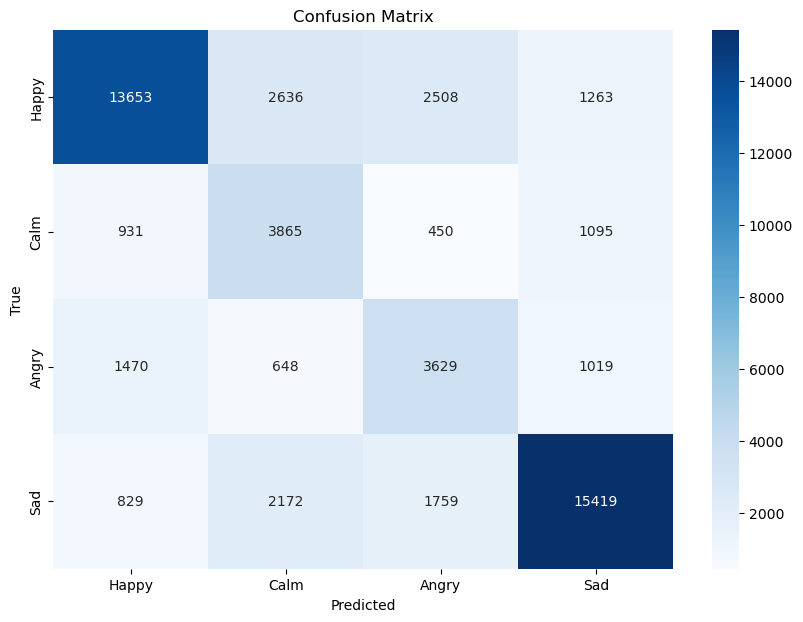

Final test accuracy: 71.29%
              precision    recall  f1-score   support

       Happy       0.81      0.68      0.74     20060
        Calm       0.41      0.61      0.49      6341
       Angry       0.43      0.54      0.48      6766
         Sad       0.82      0.76      0.79     20179

    accuracy                           0.69     53346
   macro avg       0.62      0.65      0.63     53346
weighted avg       0.72      0.69      0.70     53346



In [ ]:
v2_vgg_results = v2_vgg.k_fold_cross_test()

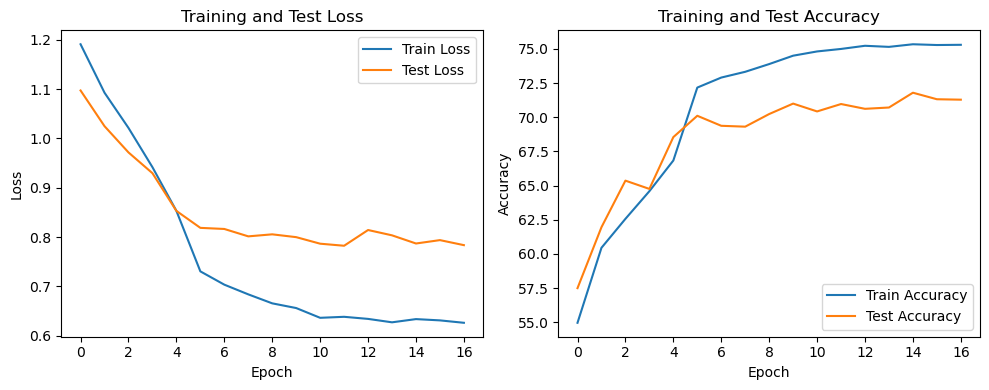

Final Training Loss: 0.6262
Final Training Accuracy: 75.30%
Final Test Loss: 0.7836
Final Test Accuracy: 71.29%


In [ ]:
v2_vgg.visualize_results(v2_vgg_results)

In [ ]:
torch.save(v2_vgg_model.state_dict(), 'v2y_vgg_model.pth')

In [ ]:
v3_vgg_model = VGG16().to(device)
v3_vgg = EmotionClassificationTrainer(dataset=dataset,
                                      model_class=VGG16,
                                      criterion_class=nn.CrossEntropyLoss,
                                      optimizer_class=optim.Adam,
                                      scheduler_class=StepLR,
                                      device=device,
                                      batch_size=16,
                                      learning_rate=0.000001,
                                      k_folds=1,
                                      class_weights=class_weights)

## DenseNet121

### 15s

In [ ]:
v1_dn_model = DenseNet121(NUM_CLASSES).to(device)
v1_dn = EmotionClassificationTrainer(dataset=dataset,
                                      model=v1_dn_model,
                                      criterion_class=nn.CrossEntropyLoss,
                                      optimizer_class=optim.Adam,
                                      scheduler_class=StepLR,
                                      device=device,
                                      batch_size=16,
                                      learning_rate=0.00001,
                                      k_folds=1,
                                      class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|████████████████████████████| 262/262 [00:51<00:00,  5.06batch/s, Loss=0.0855, Accuracy=38.7]


Epoch 1, Training Loss: 1.3638, Training Accuracy: 38.70%


Epoch 1, Test Loss: 1.2870, Test Accuracy: 55.50%


Training Epoch 2/20: 100%|████████████████████████████| 262/262 [00:52<00:00,  4.97batch/s, Loss=0.0796, Accuracy=52.1]


Epoch 2, Training Loss: 1.2692, Training Accuracy: 52.08%


Epoch 2, Test Loss: 1.2169, Test Accuracy: 59.90%


Training Epoch 3/20: 100%|██████████████████████████████| 262/262 [00:53<00:00,  4.89batch/s, Loss=0.0762, Accuracy=57]


Epoch 3, Training Loss: 1.2151, Training Accuracy: 57.04%


Epoch 3, Test Loss: 1.1869, Test Accuracy: 57.22%


Training Epoch 4/20: 100%|████████████████████████████| 262/262 [01:00<00:00,  4.30batch/s, Loss=0.0745, Accuracy=57.6]


Epoch 4, Training Loss: 1.1881, Training Accuracy: 57.59%


Epoch 4, Test Loss: 1.1753, Test Accuracy: 58.18%


Training Epoch 5/20: 100%|████████████████████████████| 262/262 [01:11<00:00,  3.67batch/s, Loss=0.0734, Accuracy=58.6]


Epoch 5, Training Loss: 1.1700, Training Accuracy: 58.59%


Epoch 5, Test Loss: 1.1543, Test Accuracy: 58.47%


Training Epoch 6/20: 100%|████████████████████████████| 262/262 [00:55<00:00,  4.74batch/s, Loss=0.0728, Accuracy=58.2]


Epoch 6, Training Loss: 1.1604, Training Accuracy: 58.23%


Epoch 6, Test Loss: 1.1632, Test Accuracy: 58.76%


Training Epoch 7/20: 100%|██████████████████████████████| 262/262 [00:57<00:00,  4.54batch/s, Loss=0.0717, Accuracy=60]


Epoch 7, Training Loss: 1.1440, Training Accuracy: 60.03%


Epoch 7, Test Loss: 1.1472, Test Accuracy: 59.62%


Training Epoch 8/20: 100%|████████████████████████████| 262/262 [00:55<00:00,  4.72batch/s, Loss=0.0719, Accuracy=59.3]


Epoch 8, Training Loss: 1.1465, Training Accuracy: 59.31%


Epoch 8, Test Loss: 1.1540, Test Accuracy: 58.56%


Training Epoch 9/20: 100%|████████████████████████████| 262/262 [00:55<00:00,  4.74batch/s, Loss=0.0714, Accuracy=60.1]


Epoch 9, Training Loss: 1.1381, Training Accuracy: 60.05%


Epoch 9, Test Loss: 1.1379, Test Accuracy: 60.00%


Training Epoch 10/20: 100%|███████████████████████████| 262/262 [00:56<00:00,  4.66batch/s, Loss=0.0715, Accuracy=60.8]


Epoch 10, Training Loss: 1.1398, Training Accuracy: 60.82%


Epoch 10, Test Loss: 1.1306, Test Accuracy: 60.38%


Training Epoch 11/20: 100%|███████████████████████████| 262/262 [00:55<00:00,  4.69batch/s, Loss=0.0712, Accuracy=59.8]


Epoch 11, Training Loss: 1.1350, Training Accuracy: 59.79%


Epoch 11, Test Loss: 1.1318, Test Accuracy: 60.48%


Training Epoch 12/20: 100%|███████████████████████████| 262/262 [00:55<00:00,  4.69batch/s, Loss=0.0716, Accuracy=60.5]


Epoch 12, Training Loss: 1.1414, Training Accuracy: 60.46%


Epoch 12, Test Loss: 1.1457, Test Accuracy: 59.90%


Training Epoch 13/20: 100%|███████████████████████████| 262/262 [00:55<00:00,  4.74batch/s, Loss=0.0719, Accuracy=59.5]


Epoch 13, Training Loss: 1.1471, Training Accuracy: 59.48%


Epoch 13, Test Loss: 1.1417, Test Accuracy: 60.38%


Training Epoch 14/20: 100%|███████████████████████████| 262/262 [00:55<00:00,  4.69batch/s, Loss=0.0709, Accuracy=59.9]


Epoch 14, Training Loss: 1.1311, Training Accuracy: 59.91%


Epoch 14, Test Loss: 1.1448, Test Accuracy: 58.85%


Training Epoch 15/20: 100%|███████████████████████████| 262/262 [00:58<00:00,  4.46batch/s, Loss=0.0711, Accuracy=60.6]


Epoch 15, Training Loss: 1.1339, Training Accuracy: 60.56%


Epoch 15, Test Loss: 1.1485, Test Accuracy: 59.04%
Early stopping triggered after 15 epochs due to test loss
Final Precision: 0.5693, Final Recall: 0.5902, Final F1-Score: 0.5771


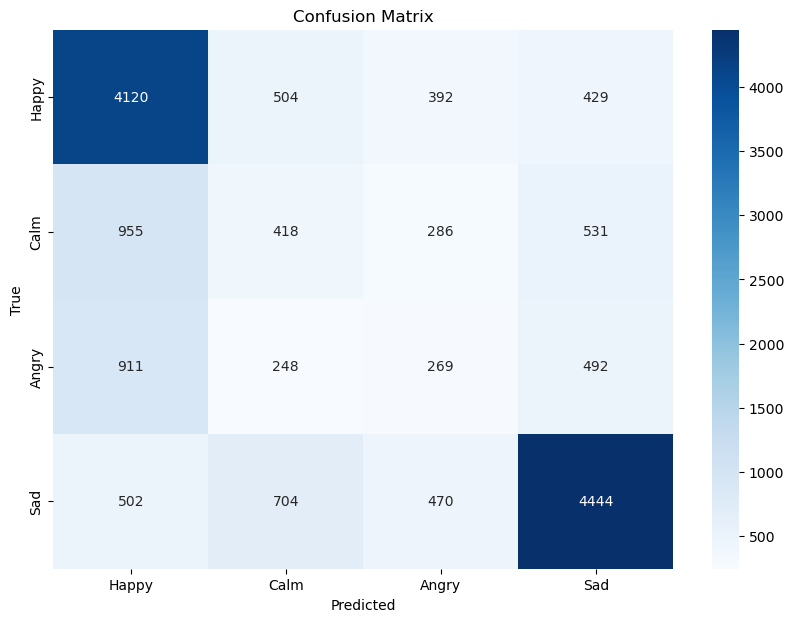

Final test accuracy: 59.04%
              precision    recall  f1-score   support

       Happy       0.64      0.76      0.69      5445
        Calm       0.22      0.19      0.21      2190
       Angry       0.19      0.14      0.16      1920
         Sad       0.75      0.73      0.74      6120

    accuracy                           0.59     15675
   macro avg       0.45      0.45      0.45     15675
weighted avg       0.57      0.59      0.58     15675



In [ ]:
v1_dn_results = v1_dn.k_fold_cross_test()

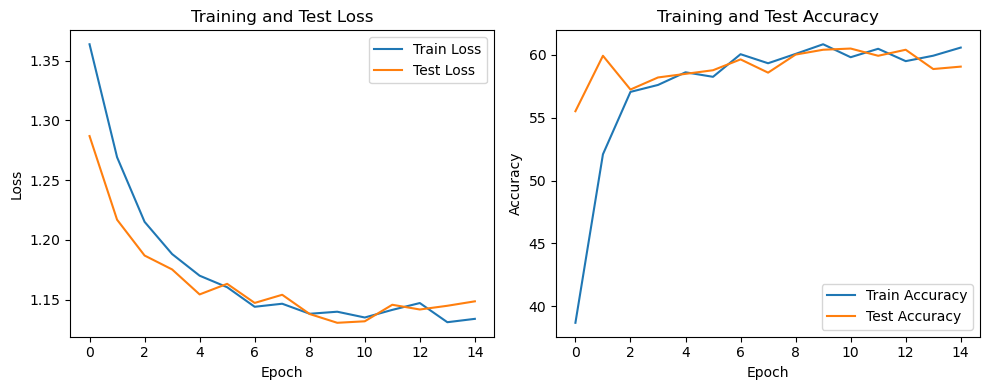

Final Training Loss: 1.1339
Final Training Accuracy: 60.56%
Final Test Loss: 1.1485
Final Test Accuracy: 59.04%


In [ ]:
v1_dn.visualize_results(v1_dn_results)

In [ ]:
torch.save(v1_dn_model.state_dict(), 'v1x_dn_model.pth')

In [ ]:
v2_dn_model = DenseNet121(NUM_CLASSES).to(device)
v2_dn = EmotionClassificationTrainer(dataset=dataset,
                                      model=v2_dn_model,
                                      criterion_class=nn.CrossEntropyLoss,
                                      optimizer_class=optim.Adam,
                                      scheduler_class=StepLR,
                                      device=device,
                                      batch_size=16,
                                      learning_rate=0.0001,
                                      k_folds=1,
                                      class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|████████████████████████████| 262/262 [00:51<00:00,  5.08batch/s, Loss=0.0768, Accuracy=52.9]


Epoch 1, Training Loss: 1.2253, Training Accuracy: 52.90%


Epoch 1, Test Loss: 1.1905, Test Accuracy: 53.88%


Training Epoch 2/20: 100%|████████████████████████████| 262/262 [00:55<00:00,  4.69batch/s, Loss=0.0715, Accuracy=58.2]


Epoch 2, Training Loss: 1.1395, Training Accuracy: 58.21%


Epoch 2, Test Loss: 1.1305, Test Accuracy: 59.52%


Training Epoch 3/20: 100%|██████████████████████████████| 262/262 [00:57<00:00,  4.52batch/s, Loss=0.0695, Accuracy=60]


Epoch 3, Training Loss: 1.1089, Training Accuracy: 60.00%


Epoch 3, Test Loss: 1.0708, Test Accuracy: 60.29%


Training Epoch 4/20: 100%|████████████████████████████| 262/262 [00:54<00:00,  4.85batch/s, Loss=0.0672, Accuracy=60.7]


Epoch 4, Training Loss: 1.0720, Training Accuracy: 60.75%


Epoch 4, Test Loss: 1.0577, Test Accuracy: 63.35%


Training Epoch 5/20: 100%|████████████████████████████| 262/262 [00:52<00:00,  4.95batch/s, Loss=0.0643, Accuracy=62.6]


Epoch 5, Training Loss: 1.0248, Training Accuracy: 62.57%


Epoch 5, Test Loss: 1.1253, Test Accuracy: 59.43%


Training Epoch 6/20: 100%|████████████████████████████| 262/262 [00:53<00:00,  4.90batch/s, Loss=0.0597, Accuracy=66.3]


Epoch 6, Training Loss: 0.9514, Training Accuracy: 66.35%


Epoch 6, Test Loss: 0.9992, Test Accuracy: 64.40%


Training Epoch 7/20: 100%|████████████████████████████| 262/262 [00:53<00:00,  4.90batch/s, Loss=0.0542, Accuracy=70.4]


Epoch 7, Training Loss: 0.8637, Training Accuracy: 70.37%


Epoch 7, Test Loss: 0.9884, Test Accuracy: 65.26%


Training Epoch 8/20: 100%|████████████████████████████| 262/262 [00:53<00:00,  4.93batch/s, Loss=0.0529, Accuracy=69.9]


Epoch 8, Training Loss: 0.8432, Training Accuracy: 69.94%


Epoch 8, Test Loss: 0.9949, Test Accuracy: 67.18%


Training Epoch 9/20: 100%|████████████████████████████| 262/262 [00:53<00:00,  4.91batch/s, Loss=0.0505, Accuracy=71.6]


Epoch 9, Training Loss: 0.8059, Training Accuracy: 71.61%


Epoch 9, Test Loss: 0.9579, Test Accuracy: 66.79%


Training Epoch 10/20: 100%|███████████████████████████| 262/262 [00:53<00:00,  4.91batch/s, Loss=0.0484, Accuracy=72.2]


Epoch 10, Training Loss: 0.7718, Training Accuracy: 72.24%


Epoch 10, Test Loss: 0.9560, Test Accuracy: 65.17%


Training Epoch 11/20: 100%|███████████████████████████| 262/262 [00:55<00:00,  4.69batch/s, Loss=0.0474, Accuracy=73.1]


Epoch 11, Training Loss: 0.7553, Training Accuracy: 73.12%


Epoch 11, Test Loss: 0.9415, Test Accuracy: 68.90%


Training Epoch 12/20: 100%|███████████████████████████| 262/262 [00:54<00:00,  4.80batch/s, Loss=0.0466, Accuracy=73.6]


Epoch 12, Training Loss: 0.7437, Training Accuracy: 73.60%


Epoch 12, Test Loss: 0.9541, Test Accuracy: 68.33%


Training Epoch 13/20: 100%|███████████████████████████| 262/262 [00:53<00:00,  4.87batch/s, Loss=0.0467, Accuracy=73.6]


Epoch 13, Training Loss: 0.7446, Training Accuracy: 73.60%


Epoch 13, Test Loss: 0.9481, Test Accuracy: 66.51%


Training Epoch 14/20: 100%|████████████████████████████| 262/262 [00:53<00:00,  4.90batch/s, Loss=0.046, Accuracy=74.2]


Epoch 14, Training Loss: 0.7341, Training Accuracy: 74.20%


Epoch 14, Test Loss: 0.9348, Test Accuracy: 68.61%


Training Epoch 15/20: 100%|███████████████████████████| 262/262 [00:54<00:00,  4.83batch/s, Loss=0.0456, Accuracy=74.9]


Epoch 15, Training Loss: 0.7271, Training Accuracy: 74.89%


Epoch 15, Test Loss: 0.9542, Test Accuracy: 68.61%


Training Epoch 16/20: 100%|███████████████████████████| 262/262 [00:53<00:00,  4.91batch/s, Loss=0.0445, Accuracy=74.7]


Epoch 16, Training Loss: 0.7099, Training Accuracy: 74.65%


Epoch 16, Test Loss: 0.9134, Test Accuracy: 69.38%


Training Epoch 17/20: 100%|███████████████████████████| 262/262 [00:53<00:00,  4.86batch/s, Loss=0.0448, Accuracy=74.5]


Epoch 17, Training Loss: 0.7142, Training Accuracy: 74.46%


Epoch 17, Test Loss: 0.9094, Test Accuracy: 67.66%


Training Epoch 18/20: 100%|███████████████████████████| 262/262 [00:54<00:00,  4.80batch/s, Loss=0.0446, Accuracy=75.7]


Epoch 18, Training Loss: 0.7112, Training Accuracy: 75.71%


Epoch 18, Test Loss: 0.9633, Test Accuracy: 65.84%


Training Epoch 19/20: 100%|███████████████████████████| 262/262 [00:53<00:00,  4.87batch/s, Loss=0.0453, Accuracy=74.6]


Epoch 19, Training Loss: 0.7227, Training Accuracy: 74.63%


Epoch 19, Test Loss: 0.9453, Test Accuracy: 67.94%


Training Epoch 20/20: 100%|███████████████████████████| 262/262 [00:53<00:00,  4.88batch/s, Loss=0.0466, Accuracy=73.7]


Epoch 20, Training Loss: 0.7430, Training Accuracy: 73.72%


Epoch 20, Test Loss: 0.9446, Test Accuracy: 68.90%
Final Precision: 0.6771, Final Recall: 0.6530, Final F1-Score: 0.6627


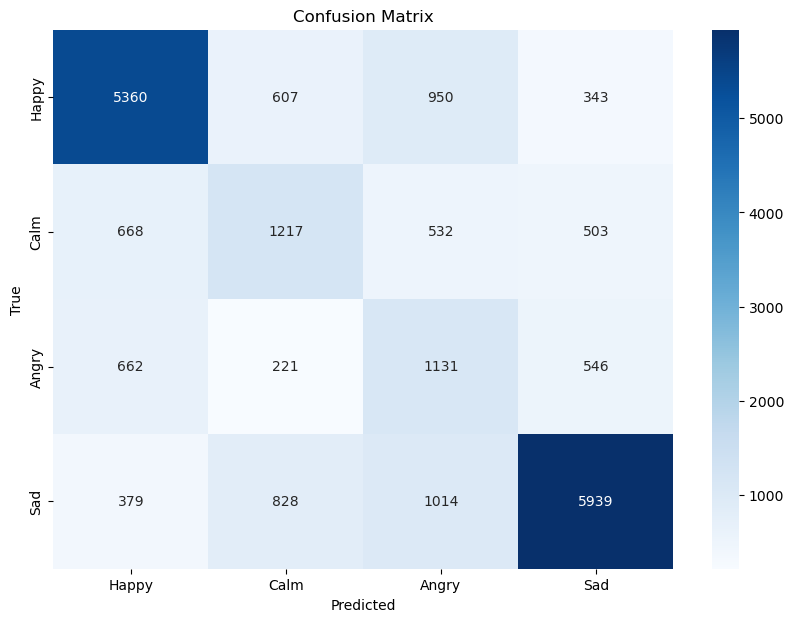

Final test accuracy: 68.90%
              precision    recall  f1-score   support

       Happy       0.76      0.74      0.75      7260
        Calm       0.42      0.42      0.42      2920
       Angry       0.31      0.44      0.37      2560
         Sad       0.81      0.73      0.77      8160

    accuracy                           0.65     20900
   macro avg       0.58      0.58      0.58     20900
weighted avg       0.68      0.65      0.66     20900



In [ ]:
v2_dn_results = v2_dn.k_fold_cross_test()

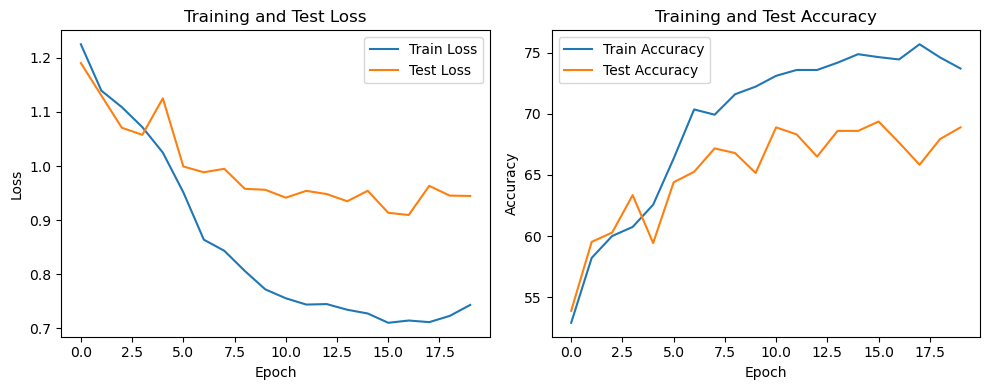

Final Training Loss: 0.7430
Final Training Accuracy: 73.72%
Final Test Loss: 0.9446
Final Test Accuracy: 68.90%


In [ ]:
v2_dn.visualize_results(v2_dn_results)

### 5s

In [ ]:
v3_dn_model = DenseNet121(NUM_CLASSES).to(device)
v3_dn = EmotionClassificationTrainer(dataset=dataset,
                                      model=v3_dn_model,
                                      criterion_class=nn.CrossEntropyLoss,
                                      optimizer_class=optim.Adam,
                                      scheduler_class=StepLR,
                                      device=device,
                                      batch_size=16,
                                      learning_rate=0.0001,
                                      k_folds=1,
                                      class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|████████████████████████████| 785/785 [02:54<00:00,  4.49batch/s, Loss=0.0723, Accuracy=56.7]


Epoch 1, Training Loss: 1.1552, Training Accuracy: 56.66%


Epoch 1, Test Loss: 1.0615, Test Accuracy: 58.80%


Training Epoch 2/20: 100%|████████████████████████████| 785/785 [02:55<00:00,  4.46batch/s, Loss=0.0675, Accuracy=59.6]


Epoch 2, Training Loss: 1.0785, Training Accuracy: 59.56%


Epoch 2, Test Loss: 1.0068, Test Accuracy: 62.30%


Training Epoch 3/20: 100%|████████████████████████████| 785/785 [02:55<00:00,  4.48batch/s, Loss=0.0622, Accuracy=62.5]


Epoch 3, Training Loss: 0.9944, Training Accuracy: 62.50%


Epoch 3, Test Loss: 0.9289, Test Accuracy: 62.72%


Training Epoch 4/20: 100%|████████████████████████████| 785/785 [02:56<00:00,  4.44batch/s, Loss=0.0567, Accuracy=65.6]


Epoch 4, Training Loss: 0.9067, Training Accuracy: 65.61%


Epoch 4, Test Loss: 0.7921, Test Accuracy: 67.97%


Training Epoch 5/20: 100%|████████████████████████████| 785/785 [02:57<00:00,  4.42batch/s, Loss=0.0507, Accuracy=68.5]


Epoch 5, Training Loss: 0.8113, Training Accuracy: 68.52%


Epoch 5, Test Loss: 0.7990, Test Accuracy: 67.14%


Training Epoch 6/20: 100%|████████████████████████████| 785/785 [02:56<00:00,  4.44batch/s, Loss=0.0398, Accuracy=75.9]


Epoch 6, Training Loss: 0.6359, Training Accuracy: 75.93%


Epoch 6, Test Loss: 0.6453, Test Accuracy: 74.79%


Training Epoch 7/20: 100%|████████████████████████████| 785/785 [02:58<00:00,  4.40batch/s, Loss=0.0339, Accuracy=79.5]


Epoch 7, Training Loss: 0.5416, Training Accuracy: 79.46%


Epoch 7, Test Loss: 0.6159, Test Accuracy: 75.94%


Training Epoch 8/20: 100%|████████████████████████████| 785/785 [02:57<00:00,  4.41batch/s, Loss=0.0301, Accuracy=81.4]


Epoch 8, Training Loss: 0.4818, Training Accuracy: 81.38%


Epoch 8, Test Loss: 0.5633, Test Accuracy: 80.02%


Training Epoch 9/20: 100%|████████████████████████████| 785/785 [02:57<00:00,  4.43batch/s, Loss=0.0282, Accuracy=82.6]


Epoch 9, Training Loss: 0.4502, Training Accuracy: 82.64%


Epoch 9, Test Loss: 0.5876, Test Accuracy: 79.38%


Training Epoch 10/20: 100%|███████████████████████████| 785/785 [02:57<00:00,  4.43batch/s, Loss=0.0264, Accuracy=84.1]


Epoch 10, Training Loss: 0.4217, Training Accuracy: 84.06%


Epoch 10, Test Loss: 0.5754, Test Accuracy: 79.89%


Training Epoch 11/20: 100%|███████████████████████████| 785/785 [02:56<00:00,  4.44batch/s, Loss=0.0247, Accuracy=84.9]


Epoch 11, Training Loss: 0.3956, Training Accuracy: 84.86%


Epoch 11, Test Loss: 0.5441, Test Accuracy: 80.43%


Training Epoch 12/20: 100%|████████████████████████████| 785/785 [03:06<00:00,  4.21batch/s, Loss=0.024, Accuracy=84.6]


Epoch 12, Training Loss: 0.3829, Training Accuracy: 84.64%


Epoch 12, Test Loss: 0.5639, Test Accuracy: 79.60%


Training Epoch 13/20: 100%|███████████████████████████| 785/785 [03:06<00:00,  4.20batch/s, Loss=0.0236, Accuracy=85.3]


Epoch 13, Training Loss: 0.3770, Training Accuracy: 85.31%


Epoch 13, Test Loss: 0.5584, Test Accuracy: 80.15%


Training Epoch 14/20: 100%|███████████████████████████| 785/785 [03:05<00:00,  4.22batch/s, Loss=0.0238, Accuracy=85.6]


Epoch 14, Training Loss: 0.3799, Training Accuracy: 85.63%


Epoch 14, Test Loss: 0.5327, Test Accuracy: 81.39%


Training Epoch 15/20: 100%|███████████████████████████| 785/785 [03:07<00:00,  4.18batch/s, Loss=0.0233, Accuracy=85.4]


Epoch 15, Training Loss: 0.3725, Training Accuracy: 85.41%


Epoch 15, Test Loss: 0.5406, Test Accuracy: 80.69%


Training Epoch 16/20: 100%|█████████████████████████████| 785/785 [03:02<00:00,  4.30batch/s, Loss=0.0226, Accuracy=86]


Epoch 16, Training Loss: 0.3615, Training Accuracy: 85.99%


Epoch 16, Test Loss: 0.5452, Test Accuracy: 80.75%


Training Epoch 17/20: 100%|███████████████████████████| 785/785 [03:07<00:00,  4.19batch/s, Loss=0.0236, Accuracy=85.2]


Epoch 17, Training Loss: 0.3772, Training Accuracy: 85.17%


Epoch 17, Test Loss: 0.5439, Test Accuracy: 81.23%


Training Epoch 18/20: 100%|███████████████████████████| 785/785 [03:09<00:00,  4.14batch/s, Loss=0.0224, Accuracy=86.1]


Epoch 18, Training Loss: 0.3585, Training Accuracy: 86.09%


Epoch 18, Test Loss: 0.5454, Test Accuracy: 81.17%


Training Epoch 19/20: 100%|█████████████████████████████| 785/785 [03:00<00:00,  4.34batch/s, Loss=0.0225, Accuracy=86]


Epoch 19, Training Loss: 0.3590, Training Accuracy: 85.97%


Epoch 19, Test Loss: 0.5323, Test Accuracy: 80.62%


Training Epoch 20/20: 100%|███████████████████████████| 785/785 [03:02<00:00,  4.31batch/s, Loss=0.0229, Accuracy=85.9]


Epoch 20, Training Loss: 0.3668, Training Accuracy: 85.88%


Epoch 20, Test Loss: 0.5561, Test Accuracy: 80.27%
Final Precision: 0.7833, Final Recall: 0.7576, Final F1-Score: 0.7651


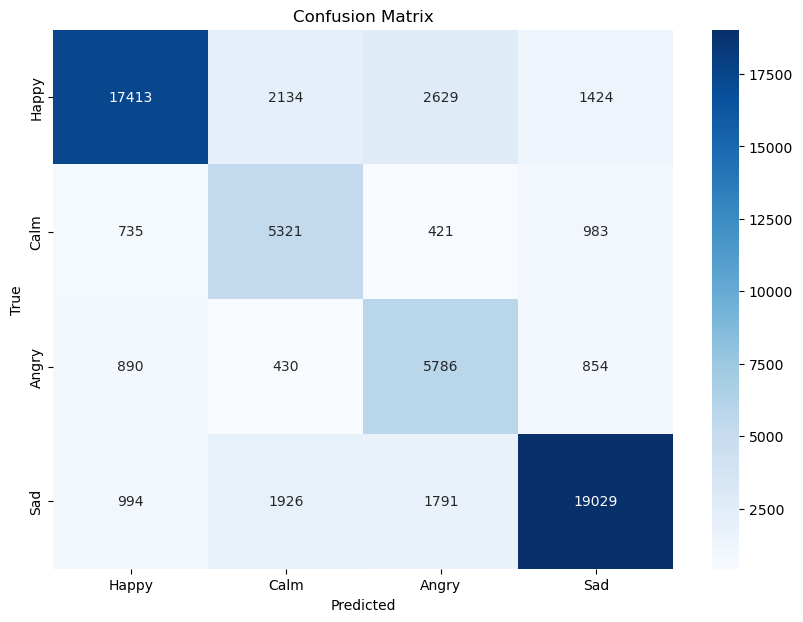

Final test accuracy: 80.27%
              precision    recall  f1-score   support

       Happy       0.87      0.74      0.80     23600
        Calm       0.54      0.71      0.62      7460
       Angry       0.54      0.73      0.62      7960
         Sad       0.85      0.80      0.83     23740

    accuracy                           0.76     62760
   macro avg       0.70      0.74      0.72     62760
weighted avg       0.78      0.76      0.77     62760



In [ ]:
v3_dn_results = v3_dn.k_fold_cross_test()

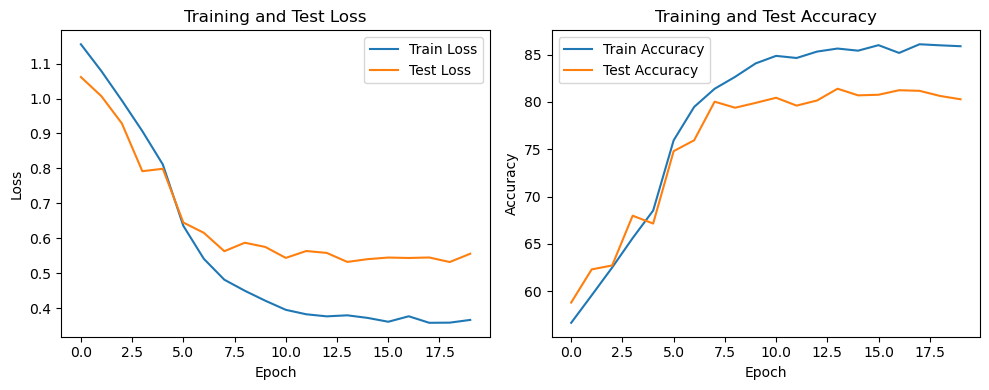

Final Training Loss: 0.3668
Final Training Accuracy: 85.88%
Final Test Loss: 0.5561
Final Test Accuracy: 80.27%


In [ ]:
v3_dn.visualize_results(v3_dn_results)

In [ ]:
torch.save(v3_dn_model.state_dict(), 'v3y_dn_model.pth')

## Ensemble

### 15s

In [ ]:
es_resnet50_model = ResNet50(NUM_CLASSES).to(device)
es_vgg16_model = VGG16(NUM_CLASSES).to(device)
es_dn121_model = DenseNet121(NUM_CLASSES).to(device)

es_resnet50_model.load_state_dict(torch.load('v1x_rn_model.pth', weights_only=True))
es_vgg16_model.load_state_dict(torch.load('v1x_vgg_model.pth', weights_only=True))
es_dn121_model.load_state_dict(torch.load('v1x_dn_model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
v1_es_model = StackingEnsemble(NUM_CLASSES).to(device)
v1_es_model.resnet50 = es_resnet50_model
v1_es_model.vgg16 = es_vgg16_model
v1_es_model.densenet121 = es_dn121_model

In [ ]:
v1_es = EmotionClassificationTrainer(dataset=dataset,
                                     model=v1_es_model,
                                     criterion_class=nn.CrossEntropyLoss,
                                     optimizer_class=optim.Adam,
                                     scheduler_class=StepLR,
                                     device=device,
                                     batch_size=16,
                                     learning_rate=0.0001,
                                     k_folds=1,
                                     class_weights=class_weights)

In [ ]:
v1_es_results = v1_es.k_fold_cross_test()

Single Train-Test Split


Training Epoch 1/20: 100%|████████████████████████████| 262/262 [17:51<00:00,  4.09s/batch, Loss=0.0752, Accuracy=55.1]


Epoch 1, Training Loss: 1.1988, Training Accuracy: 55.12%


Epoch 1, Test Loss: 1.2088, Test Accuracy: 61.63%


Training Epoch 2/20: 100%|████████████████████████████| 262/262 [18:46<00:00,  4.30s/batch, Loss=0.0709, Accuracy=59.2]


Epoch 2, Training Loss: 1.1309, Training Accuracy: 59.24%


Epoch 2, Test Loss: 1.1151, Test Accuracy: 56.46%


Training Epoch 3/20: 100%|████████████████████████████| 262/262 [23:56<00:00,  5.48s/batch, Loss=0.0679, Accuracy=59.8]


Epoch 3, Training Loss: 1.0831, Training Accuracy: 59.77%


Epoch 3, Test Loss: 1.1290, Test Accuracy: 58.85%


Training Epoch 4/20: 100%|████████████████████████████| 262/262 [20:26<00:00,  4.68s/batch, Loss=0.0677, Accuracy=59.6]


Epoch 4, Training Loss: 1.0788, Training Accuracy: 59.65%


Epoch 4, Test Loss: 1.0946, Test Accuracy: 59.52%


Training Epoch 5/20:   2%|▌                             | 5/262 [00:24<21:17,  4.97s/batch, Loss=0.0612, Accuracy=68.8]

KeyboardInterrupt



In [ ]:
v1_es.visualize_results(v1_es_results)

### 5s

In [ ]:
es_resnet50_model = ResNet50(NUM_CLASSES).to(device)
es_vgg16_model = VGG16(NUM_CLASSES).to(device)
es_dn121_model = DenseNet121(NUM_CLASSES).to(device)

es_resnet50_model.load_state_dict(torch.load(DRIVE + 'v2y_rn_model.pth', weights_only=True))
es_vgg16_model.load_state_dict(torch.load(DRIVE + 'v2y_vgg_model.pth', weights_only=True))
es_dn121_model.load_state_dict(torch.load(DRIVE + 'v3y_dn_model.pth', weights_only=True))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 186MB/s]


<All keys matched successfully>

In [ ]:
v2_es_model = StackingEnsemble(NUM_CLASSES).to(device)
v2_es_model.resnet50 = es_resnet50_model
v2_es_model.vgg16 = es_vgg16_model
v2_es_model.densenet121 = es_dn121_model

In [ ]:
v2_es = EmotionClassificationTrainer(dataset=dataset,
                                     model=v2_es_model,
                                     criterion_class=nn.CrossEntropyLoss,
                                     optimizer_class=optim.Adam,
                                     scheduler_class=StepLR,
                                     device=device,
                                     batch_size=16,
                                     learning_rate=0.0001,
                                     k_folds=1,
                                     class_weights=class_weights)

Single Train-Test Split


Training Epoch 1/20: 100%|██████████| 785/785 [03:32<00:00,  3.69batch/s, Loss=0.0684, Accuracy=59.1]


Epoch 1, Training Loss: 1.0933, Training Accuracy: 59.06%


Epoch 1, Test Loss: 0.8246, Test Accuracy: 70.71%


Training Epoch 2/20: 100%|██████████| 785/785 [03:32<00:00,  3.69batch/s, Loss=0.0539, Accuracy=65.9]


Epoch 2, Training Loss: 0.8624, Training Accuracy: 65.91%


Epoch 2, Test Loss: 0.7128, Test Accuracy: 73.87%


Training Epoch 3/20: 100%|██████████| 785/785 [03:33<00:00,  3.68batch/s, Loss=0.0495, Accuracy=68.4]


Epoch 3, Training Loss: 0.7920, Training Accuracy: 68.44%


Epoch 3, Test Loss: 0.7394, Test Accuracy: 70.91%


Training Epoch 4/20: 100%|██████████| 785/785 [03:34<00:00,  3.66batch/s, Loss=0.0447, Accuracy=72.2]


Epoch 4, Training Loss: 0.7151, Training Accuracy: 72.17%


Epoch 4, Test Loss: 0.6390, Test Accuracy: 75.14%


Training Epoch 5/20: 100%|██████████| 785/785 [03:33<00:00,  3.68batch/s, Loss=0.0427, Accuracy=73.9]


Epoch 5, Training Loss: 0.6827, Training Accuracy: 73.88%


Epoch 5, Test Loss: 0.6321, Test Accuracy: 75.30%


Training Epoch 6/20: 100%|██████████| 785/785 [03:31<00:00,  3.70batch/s, Loss=0.0364, Accuracy=77.6]


Epoch 6, Training Loss: 0.5816, Training Accuracy: 77.59%


Epoch 6, Test Loss: 0.5404, Test Accuracy: 80.82%


Training Epoch 7/20: 100%|██████████| 785/785 [03:32<00:00,  3.69batch/s, Loss=0.0311, Accuracy=81.6]


Epoch 7, Training Loss: 0.4972, Training Accuracy: 81.59%


Epoch 7, Test Loss: 0.5145, Test Accuracy: 80.82%


Training Epoch 8/20: 100%|██████████| 785/785 [03:32<00:00,  3.69batch/s, Loss=0.0283, Accuracy=82.8]


Epoch 8, Training Loss: 0.4532, Training Accuracy: 82.81%


Epoch 8, Test Loss: 0.4731, Test Accuracy: 83.40%


Training Epoch 9/20: 100%|██████████| 785/785 [03:32<00:00,  3.69batch/s, Loss=0.0267, Accuracy=84]


Epoch 9, Training Loss: 0.4273, Training Accuracy: 84.03%


Epoch 9, Test Loss: 0.4780, Test Accuracy: 84.54%


Training Epoch 10/20: 100%|██████████| 785/785 [03:33<00:00,  3.68batch/s, Loss=0.0257, Accuracy=85.1]


Epoch 10, Training Loss: 0.4107, Training Accuracy: 85.05%


Epoch 10, Test Loss: 0.4652, Test Accuracy: 85.21%


Training Epoch 11/20: 100%|██████████| 785/785 [03:32<00:00,  3.69batch/s, Loss=0.0243, Accuracy=85.3]


Epoch 11, Training Loss: 0.3884, Training Accuracy: 85.33%


Epoch 11, Test Loss: 0.4661, Test Accuracy: 84.48%


Training Epoch 12/20: 100%|██████████| 785/785 [03:32<00:00,  3.70batch/s, Loss=0.0242, Accuracy=85.4]


Epoch 12, Training Loss: 0.3862, Training Accuracy: 85.40%


Epoch 12, Test Loss: 0.4733, Test Accuracy: 83.81%


Training Epoch 13/20: 100%|██████████| 785/785 [03:32<00:00,  3.70batch/s, Loss=0.0245, Accuracy=85.5]


Epoch 13, Training Loss: 0.3918, Training Accuracy: 85.52%


Epoch 13, Test Loss: 0.4628, Test Accuracy: 83.91%


Training Epoch 14/20: 100%|██████████| 785/785 [03:32<00:00,  3.70batch/s, Loss=0.0241, Accuracy=85.5]


Epoch 14, Training Loss: 0.3858, Training Accuracy: 85.54%


Epoch 14, Test Loss: 0.4566, Test Accuracy: 85.02%


Training Epoch 15/20: 100%|██████████| 785/785 [03:32<00:00,  3.70batch/s, Loss=0.024, Accuracy=85.6]


Epoch 15, Training Loss: 0.3837, Training Accuracy: 85.58%


Epoch 15, Test Loss: 0.4470, Test Accuracy: 83.72%


Training Epoch 16/20: 100%|██████████| 785/785 [03:32<00:00,  3.69batch/s, Loss=0.024, Accuracy=85.4]


Epoch 16, Training Loss: 0.3841, Training Accuracy: 85.41%


Epoch 16, Test Loss: 0.4605, Test Accuracy: 85.34%


Training Epoch 17/20: 100%|██████████| 785/785 [03:31<00:00,  3.70batch/s, Loss=0.0239, Accuracy=85.6]


Epoch 17, Training Loss: 0.3826, Training Accuracy: 85.59%


Epoch 17, Test Loss: 0.4544, Test Accuracy: 84.80%


Training Epoch 18/20: 100%|██████████| 785/785 [03:32<00:00,  3.70batch/s, Loss=0.0237, Accuracy=85.9]


Epoch 18, Training Loss: 0.3790, Training Accuracy: 85.86%


Epoch 18, Test Loss: 0.4524, Test Accuracy: 85.02%


Training Epoch 19/20: 100%|██████████| 785/785 [03:32<00:00,  3.70batch/s, Loss=0.0236, Accuracy=85.9]


Epoch 19, Training Loss: 0.3776, Training Accuracy: 85.86%


Epoch 19, Test Loss: 0.4504, Test Accuracy: 84.51%


Training Epoch 20/20: 100%|██████████| 785/785 [03:31<00:00,  3.70batch/s, Loss=0.024, Accuracy=85.8]


Epoch 20, Training Loss: 0.3833, Training Accuracy: 85.84%


Epoch 20, Test Loss: 0.4680, Test Accuracy: 85.05%
Early stopping triggered after 20 epochs due to test loss
Final Precision: 0.8270, Final Recall: 0.8132, Final F1-Score: 0.8173


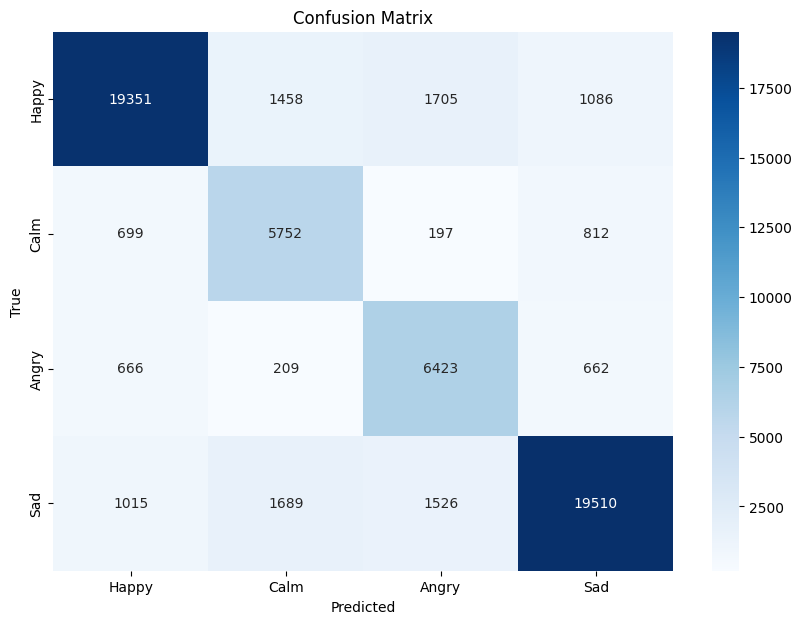

Final test accuracy: 85.05%
              precision    recall  f1-score   support

       Happy       0.89      0.82      0.85     23600
        Calm       0.63      0.77      0.69      7460
       Angry       0.65      0.81      0.72      7960
         Sad       0.88      0.82      0.85     23740

    accuracy                           0.81     62760
   macro avg       0.76      0.80      0.78     62760
weighted avg       0.83      0.81      0.82     62760



In [ ]:
v2_es_results = v2_es.k_fold_cross_test()

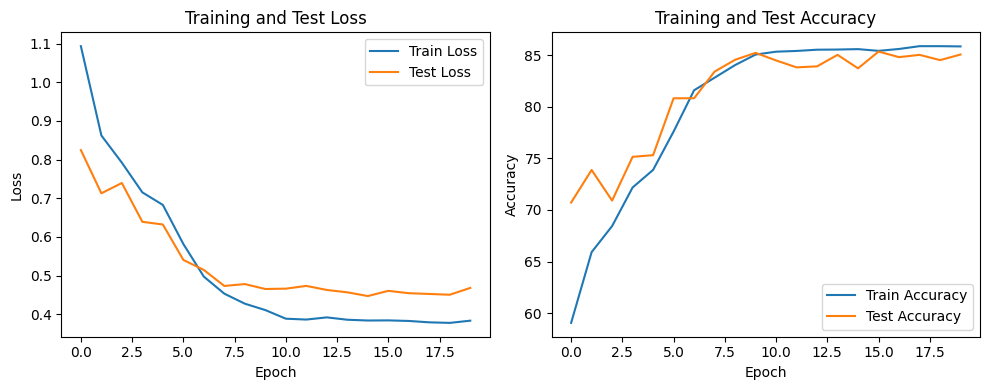

Final Training Loss: 0.3833
Final Training Accuracy: 85.84%
Final Test Loss: 0.4680
Final Test Accuracy: 85.05%


In [ ]:
v2_es.visualize_results(v2_es_results)

In [ ]:
torch.save(v2_es_model.state_dict(), DRIVE + 'v2y_es_model.pth')

### 5-Fold

In [ ]:
v3_es_resnet50_model = ResNet50(NUM_CLASSES).to(device)
v3_es_vgg16_model = VGG16(NUM_CLASSES).to(device)
v3_es_dn121_model = DenseNet121(NUM_CLASSES).to(device)

v3_es_resnet50_model.load_state_dict(torch.load(DRIVE + 'v2y_rn_model.pth', weights_only=True))
v3_es_vgg16_model.load_state_dict(torch.load(DRIVE + 'v2y_vgg_model.pth', weights_only=True))
v3_es_dn121_model.load_state_dict(torch.load(DRIVE + 'v3y_dn_model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
v3_es = EmotionClassificationTrainer(dataset=dataset,
                                     model_class=StackingEnsemble,
                                     criterion_class=nn.CrossEntropyLoss,
                                     optimizer_class=optim.Adam,
                                     scheduler_class=StepLR,
                                     device=device,
                                     batch_size=16,
                                     learning_rate=0.0001,
                                     k_folds=5,
                                     class_weights=class_weights)

In [ ]:
v3_es_results = v3_es.k_fold_cross_test()
v3_es.visualize_results(ensemble_results)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
wow = enumerate(v3_es_results)
print(list(wow))

[(0, {'train_losses': [1.0721685496864806, 0.8993742483816329, 0.834008623726049, 0.7910778322037618, 0.7438978916900173, 0.5927299267167498, 0.5214627370428128, 0.4896685740560483, 0.4531124674305794, 0.43970435527479573, 0.4243251777758264, 0.4047672134770709, 0.4092255605586395, 0.3797214792982029, 0.40328262248995955, 0.398864674093617, 0.3943200727462009, 0.39429658516577093, 0.3887055152445842, 0.3952415388433417, 1.0218882393305468, 0.8987180449780385, 0.8515141527364208, 0.7964168820791184, 0.7442411262897929, 0.6020440282905177, 0.5334125382315581, 0.488635224379172, 0.46133739683468633, 0.44287940147955707, 0.40666570822904063, 0.410751534647243, 0.4010260415304998, 0.3976743342390486, 0.3882109383014357, 0.4067816599823867, 0.39250357403497027, 0.393265983633175, 0.4010158395976018, 0.38782338548665213, 1.0517617711975316, 0.8711335744447769, 0.8099055827043619, 0.7672300502373155, 0.7153995015438954, 0.5588013134090004, 0.48661281741728446, 0.43906971310164516, 0.4276496669

In [ ]:
!nvidia-smi

Fri Jul 26 03:48:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              55W / 400W |  15869MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
for fold, result in enumerate(v3_es_results):
  print(fold, result)

0 {'train_losses': [1.0721685496864806, 0.8993742483816329, 0.834008623726049, 0.7910778322037618, 0.7438978916900173, 0.5927299267167498, 0.5214627370428128, 0.4896685740560483, 0.4531124674305794, 0.43970435527479573, 0.4243251777758264, 0.4047672134770709, 0.4092255605586395, 0.3797214792982029, 0.40328262248995955, 0.398864674093617, 0.3943200727462009, 0.39429658516577093, 0.3887055152445842, 0.3952415388433417, 1.0218882393305468, 0.8987180449780385, 0.8515141527364208, 0.7964168820791184, 0.7442411262897929, 0.6020440282905177, 0.5334125382315581, 0.488635224379172, 0.46133739683468633, 0.44287940147955707, 0.40666570822904063, 0.410751534647243, 0.4010260415304998, 0.3976743342390486, 0.3882109383014357, 0.4067816599823867, 0.39250357403497027, 0.393265983633175, 0.4010158395976018, 0.38782338548665213, 1.0517617711975316, 0.8711335744447769, 0.8099055827043619, 0.7672300502373155, 0.7153995015438954, 0.5588013134090004, 0.48661281741728446, 0.43906971310164516, 0.4276496669194

In [ ]:
for fold, result in enumerate(v3_es_results):
  print(f'Fold {fold} Final Training Loss: {result["train_losses"][-1]:.4f}')

Fold 0 Final Training Loss: 0.4201
Fold 1 Final Training Loss: 0.4201
Fold 2 Final Training Loss: 0.4201
Fold 3 Final Training Loss: 0.4201
Fold 4 Final Training Loss: 0.4201


In [ ]:
f1_train_loss = v3_es_results[0]['train_losses'][0:20]
f2_train_loss = v3_es_results[0]['train_losses'][21:40]
f3_train_loss = v3_es_results[0]['train_losses'][41:60]
f4_train_loss = v3_es_results[0]['train_losses'][61:80]
f5_train_loss = v3_es_results[0]['train_losses'][81:100]

In [ ]:
f1_test_loss = v3_es_results[0]['test_losses'][0:20]
f2_test_loss = v3_es_results[0]['test_losses'][21:40]
f3_test_loss = v3_es_results[0]['test_losses'][41:60]
f4_test_loss = v3_es_results[0]['test_losses'][61:80]
f5_test_loss = v3_es_results[0]['test_losses'][81:100]

In [ ]:
f1_train_accuracies = v3_es_results[0]['train_accuracies'][0:20]
f2_train_accuracies = v3_es_results[0]['train_accuracies'][21:40]
f3_train_accuracies = v3_es_results[0]['train_accuracies'][41:60]
f4_train_accuracies = v3_es_results[0]['train_accuracies'][61:80]
f5_train_accuracies = v3_es_results[0]['train_accuracies'][81:100]

In [ ]:
f1_test_accuracies = v3_es_results[0]['test_accuracies'][0:20]
f2_test_accuracies = v3_es_results[0]['test_accuracies'][21:40]
f3_test_accuracies = v3_es_results[0]['test_accuracies'][41:60]
f4_test_accuracies = v3_es_results[0]['test_accuracies'][61:80]
f5_test_accuracies = v3_es_results[0]['test_accuracies'][81:100]

In [ ]:
f1_train_loss

[1.0721685496864806,
 0.8993742483816329,
 0.834008623726049,
 0.7910778322037618,
 0.7438978916900173,
 0.5927299267167498,
 0.5214627370428128,
 0.4896685740560483,
 0.4531124674305794,
 0.43970435527479573,
 0.4243251777758264,
 0.4047672134770709,
 0.4092255605586395,
 0.3797214792982029,
 0.40328262248995955,
 0.398864674093617,
 0.3943200727462009,
 0.39429658516577093,
 0.3887055152445842,
 0.3952415388433417]

In [ ]:
ensemble_results = [
    {
        'train_losses': f1_train_loss,
        'train_accuracies': f1_train_accuracies,
        'test_losses': f1_test_loss,
        'test_accuracies': f1_test_accuracies
    },
    {
        'train_losses': f2_train_loss,
        'train_accuracies': f2_train_accuracies,
        'test_losses': f2_test_loss,
        'test_accuracies': f2_test_accuracies
    },
    {
        'train_losses': f3_train_loss,
        'train_accuracies': f3_train_accuracies,
        'test_losses': f3_test_loss,
        'test_accuracies': f3_test_accuracies
    },
    {
        'train_losses': f4_train_loss,
        'train_accuracies': f4_train_accuracies,
        'test_losses': f4_test_loss,
        'test_accuracies': f4_test_accuracies
    },
    {
        'train_losses': f5_train_loss,
        'train_accuracies': f5_train_accuracies,
        'test_losses': f5_test_loss,
        'test_accuracies': f5_test_accuracies
    },
]
ensemble_results[0]

{'train_losses': [1.0721685496864806,
  0.8993742483816329,
  0.834008623726049,
  0.7910778322037618,
  0.7438978916900173,
  0.5927299267167498,
  0.5214627370428128,
  0.4896685740560483,
  0.4531124674305794,
  0.43970435527479573,
  0.4243251777758264,
  0.4047672134770709,
  0.4092255605586395,
  0.3797214792982029,
  0.40328262248995955,
  0.398864674093617,
  0.3943200727462009,
  0.39429658516577093,
  0.3887055152445842,
  0.3952415388433417],
 'train_accuracies': [56.116025181289345,
  64.4274444178819,
  66.84197944059288,
  68.90588891545143,
  71.137142401785,
  77.1137142401785,
  79.7752808988764,
  80.76340744282413,
  83.14606741573034,
  83.02653597896247,
  83.40106781416846,
  84.54060084468883,
  84.47685074507929,
  85.37732090206391,
  84.30153797115308,
  84.77966371822455,
  85.35341461471033,
  85.32153956490556,
  84.71591361861503,
  85.08247669136983],
 'test_losses': [0.7282078401729237,
  0.7333397468183246,
  0.6405058640060086,
  0.5748175789606829,
  

In [ ]:
v3_es_results

[{'train_losses': [1.0721685496864806,
   0.8993742483816329,
   0.834008623726049,
   0.7910778322037618,
   0.7438978916900173,
   0.5927299267167498,
   0.5214627370428128,
   0.4896685740560483,
   0.4531124674305794,
   0.43970435527479573,
   0.4243251777758264,
   0.4047672134770709,
   0.4092255605586395,
   0.3797214792982029,
   0.40328262248995955,
   0.398864674093617,
   0.3943200727462009,
   0.39429658516577093,
   0.3887055152445842,
   0.3952415388433417,
   1.0218882393305468,
   0.8987180449780385,
   0.8515141527364208,
   0.7964168820791184,
   0.7442411262897929,
   0.6020440282905177,
   0.5334125382315581,
   0.488635224379172,
   0.46133739683468633,
   0.44287940147955707,
   0.40666570822904063,
   0.410751534647243,
   0.4010260415304998,
   0.3976743342390486,
   0.3882109383014357,
   0.4067816599823867,
   0.39250357403497027,
   0.393265983633175,
   0.4010158395976018,
   0.38782338548665213,
   1.0517617711975316,
   0.8711335744447769,
   0.8099055827

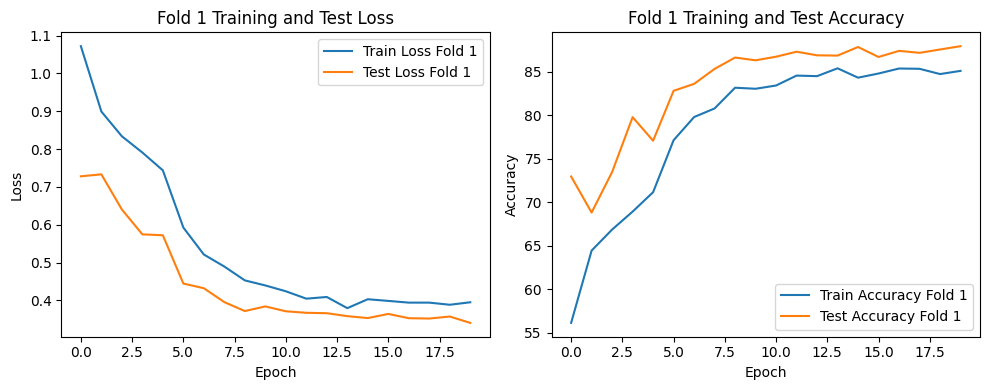

Fold 1 Final Training Loss: 0.3952
Fold 1 Final Training Accuracy: 85.08%
Fold 1 Final Test Loss: 0.3408
Fold 1 Final Test Accuracy: 87.92%


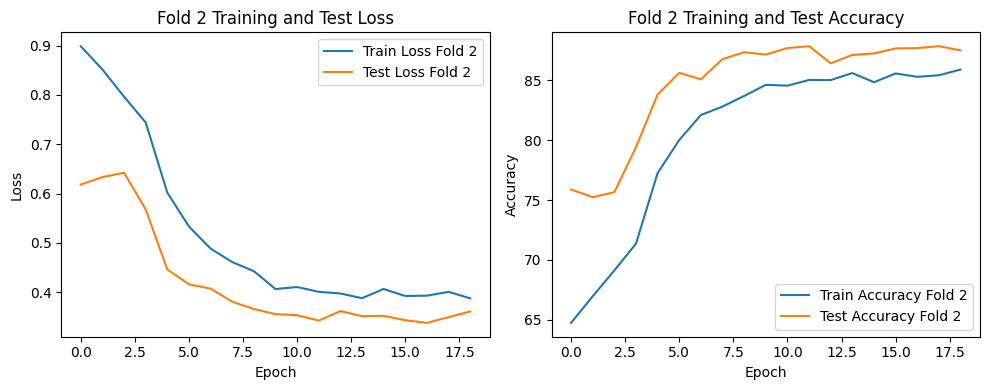

Fold 2 Final Training Loss: 0.3878
Fold 2 Final Training Accuracy: 85.90%
Fold 2 Final Test Loss: 0.3612
Fold 2 Final Test Accuracy: 87.51%


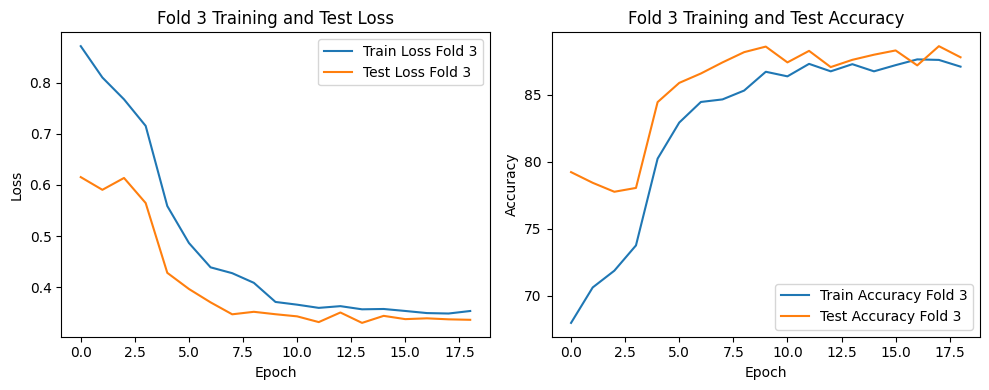

Fold 3 Final Training Loss: 0.3538
Fold 3 Final Training Accuracy: 87.09%
Fold 3 Final Test Loss: 0.3366
Fold 3 Final Test Accuracy: 87.79%


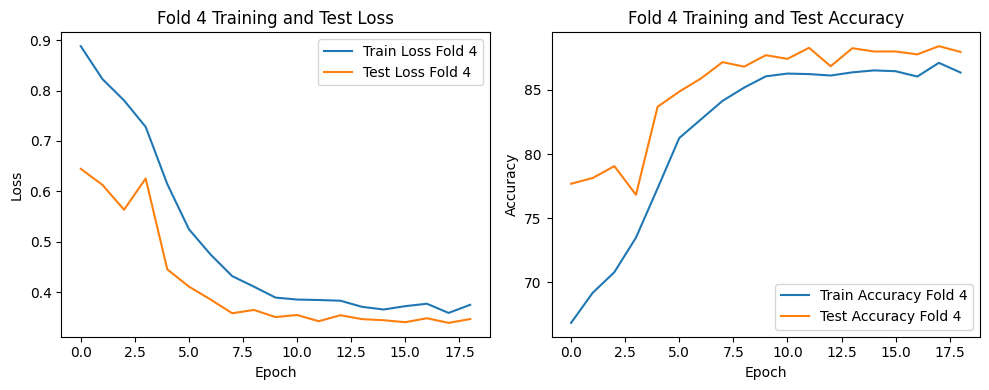

Fold 4 Final Training Loss: 0.3746
Fold 4 Final Training Accuracy: 86.34%
Fold 4 Final Test Loss: 0.3464
Fold 4 Final Test Accuracy: 87.95%


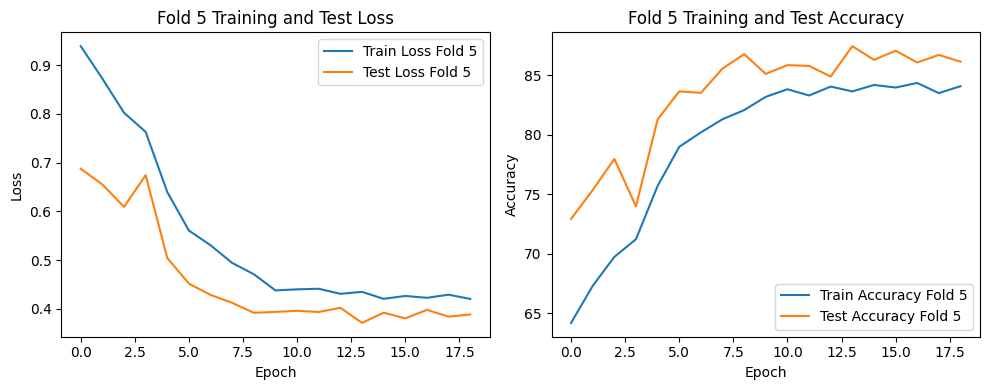

Fold 5 Final Training Loss: 0.4201
Fold 5 Final Training Accuracy: 84.08%
Fold 5 Final Test Loss: 0.3882
Fold 5 Final Test Accuracy: 86.13%


In [ ]:
v3_es.visualize_results(ensemble_results)

In [ ]:
ensemble_results

[{'train_losses': [1.0721685496864806,
   0.8993742483816329,
   0.834008623726049,
   0.7910778322037618,
   0.7438978916900173,
   0.5927299267167498,
   0.5214627370428128,
   0.4896685740560483,
   0.4531124674305794,
   0.43970435527479573,
   0.4243251777758264,
   0.4047672134770709,
   0.4092255605586395,
   0.3797214792982029,
   0.40328262248995955,
   0.398864674093617,
   0.3943200727462009,
   0.39429658516577093,
   0.3887055152445842,
   0.3952415388433417],
  'train_accuracies': [56.116025181289345,
   64.4274444178819,
   66.84197944059288,
   68.90588891545143,
   71.137142401785,
   77.1137142401785,
   79.7752808988764,
   80.76340744282413,
   83.14606741573034,
   83.02653597896247,
   83.40106781416846,
   84.54060084468883,
   84.47685074507929,
   85.37732090206391,
   84.30153797115308,
   84.77966371822455,
   85.35341461471033,
   85.32153956490556,
   84.71591361861503,
   85.08247669136983],
  'test_losses': [0.7282078401729237,
   0.7333397468183246,
   0